## The code for figure 3 - studying peaks of dynamical correlation

In [1]:

import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
#from lempel_ziv_complexity import lempel_ziv_complexity
import seaborn as sns

import saving as sv
import mattepy as mp
import utils_avalanches as av
import Utils_FC as fc

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS




In [2]:

arr_mu = os.listdir(path+'seeg_fif_data/music')
sound_list=['speech', 'music','rest']
subject_list=[]
for st in arr_mu: 
    subject_list.append(st.partition('_')[0])
    print(st.partition('_')[0])
 
subject_list=[s for s in subject_list if 's' in s]
print()

subject_list.remove('sub-3ef8645f99c5')
subject_list.remove('sub-aea837fa1826')
subject_list.remove('sub-d9c48230fb78')

print(subject_list)

sub-14c725b6b803
sub-26176ef8a8d0
sub-28e70e7c7fbb
sub-3ef8645f99c5
sub-4247d6d6cdbf
sub-44375d501493
sub-45a6830d263e
sub-82e330f8aadd
sub-83ebd5328120
sub-95a634be7e05
sub-9d783b836f5e
sub-a4e7fc9daa96
sub-aea837fa1826
sub-c1b7ce54ce05
sub-c2a96116ddc4
sub-cacae171ee15
sub-d9c48230fb78
sub-e0bb6ccef2a5
sub-ebf231d97f73
sub-fccb4adbfadc

['sub-14c725b6b803', 'sub-26176ef8a8d0', 'sub-28e70e7c7fbb', 'sub-4247d6d6cdbf', 'sub-44375d501493', 'sub-45a6830d263e', 'sub-82e330f8aadd', 'sub-83ebd5328120', 'sub-95a634be7e05', 'sub-9d783b836f5e', 'sub-a4e7fc9daa96', 'sub-c1b7ce54ce05', 'sub-c2a96116ddc4', 'sub-cacae171ee15', 'sub-e0bb6ccef2a5', 'sub-ebf231d97f73', 'sub-fccb4adbfadc']


In [3]:
len(subject_list)

17

Computation subject list 

In [4]:
def Significance(TSr,TSm,TSs,nsample=1000):
    
    tlen=TSr.shape[0] #time points
    N=TSr.shape[1] #number of regions
    
    # Observed Activty Engagements in r,m,s
    AEr=np.mean(TSr,axis=0)
    AEm=np.mean(TSm,axis=0)
    AEs=np.mean(TSs,axis=0)
    
    # Observed Delta Activty Engagements in m,s with respect to r
    DeltaAEm=AEm-AEr
    DeltaAEs=AEs-AEr
    
    # Obtain 1000 'AE' and 'DeltaAE' null models
    AEr_nulls=np.zeros((nsample,N))
    AEm_nulls=np.zeros((nsample,N))
    AEs_nulls=np.zeros((nsample,N))
    
    DeltaAEm_nulls=np.zeros((nsample,N))
    DeltaAEs_nulls=np.zeros((nsample,N))
    
    for i in range(nsample):
        # define surrogate matrices by randomly mixing the columns of TSr,TSm,TSs 
        X=np.vstack((TSr,TSm,TSs))
        np.random.shuffle(X)
        X = X.reshape(3, tlen, N)
        
        AEr_nulls[i]=np.mean(X[0],axis=0)
        AEm_nulls[i]=np.mean(X[1],axis=0)
        AEs_nulls[i]=np.mean(X[2],axis=0)
        
        # define delta surrogate matrices 
        X=np.vstack((TSr,TSm))
        np.random.shuffle(X)
        X = X.reshape(2, tlen, N)
        DeltaAEm_nulls[i]=np.mean(X[1],axis=0)-np.mean(X[0],axis=0)
        
        X=np.vstack((TSr,TSs))
        np.random.shuffle(X)
        X = X.reshape(2, tlen, N)
        DeltaAEs_nulls[i]=np.mean(X[1],axis=0)-np.mean(X[0],axis=0)        
    
    # Find significance 
    
    B=np.tile(AEr,(nsample,1))>AEr_nulls
    AEr_significance=1-np.sum(B,axis=0)/nsample
    
    B=np.tile(AEm,(nsample,1))>AEm_nulls
    AEm_significance=1-np.sum(B,axis=0)/nsample
    
    B=np.tile(AEs,(nsample,1))>AEs_nulls
    AEs_significance=1-np.sum(B,axis=0)/nsample
    
    B=np.tile(DeltaAEm,(nsample,1))>DeltaAEm_nulls
    DeltaAEm_significance=1-np.sum(B,axis=0)/nsample
    
    B=np.tile(DeltaAEs,(nsample,1))>DeltaAEs_nulls
    DeltaAEs_significance=1-np.sum(B,axis=0)/nsample
        
    return AEr_significance, AEm_significance, AEs_significance, DeltaAEm_significance, DeltaAEs_significance

def bars(p, bottom, top):
    # Get info about y-axis
    yrange = top - bottom

    # Columns corresponding to the datasets of interest
    x1 = 1
    x2 = 2
    # What level is this bar among the bars above the plot?
    level = 1
    # Plot the bar
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level

    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')
    plt.ylim((bottom-top/8, top+top/4))

def bars_diff(p, bottom, top):
    # Get info about y-axis
    yrange = top - bottom

    # Columns corresponding to the datasets of interest
    x1 = 1
    x2 = 2
    # What level is this bar among the bars above the plot?
    level = 1
    # Plot the bar
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Significance level

    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    text_height = bar_height + (yrange * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')
    plt.ylim((-0.24,0.44))

    
def Gtest(a,b,N=5000):
    nsubs=len(a)
    diff=a-b
    diff_bin=np.where(diff>0,1,0)
    observed=np.sum(diff_bin)
    pool=[]
    for i in range(N):
        pool.append(np.sum(np.random.randint(2, size=nsubs)))
    if observed<np.mean(pool):
        p=np.sum(np.asarray(pool)<observed)/N
    else:
        p=np.sum(np.asarray(pool)>observed)/N
    return p

In [5]:


for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
        print(f.keys())
        print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
        #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

    ## Cleaning from artifacts
    #List of bad channels indices
    ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

    clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
    ch_H_i[subject]=[i for i, ch in enumerate(clean_chnames) if 'H' in ch]
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)
        


#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)

subject_list.remove('sub-82e330f8aadd')



NameError: name 'total_channels_set' is not defined

Here we compute the null models for the engagement

In [143]:
#datatipe='hgenv_down100'
#data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 


 


for isub, subject in enumerate(['sub-3ef8645f99c5','sub-aea837fa1826','sub-d9c48230fb78']):
    zdata={}
    significance={}
    for sound in sound_list:

        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            print(f.keys())
            print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            print(f.keys())
            print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        zdata[sound]=np.delete(data_raw, ch_i, axis=0) 
    
    zdata['music']=scipy.stats.zscore(zdata['music'], axis=1)
    zdata['rest']=scipy.stats.zscore(zdata['rest'], axis=1)
    zdata['speech']=scipy.stats.zscore(zdata['speech'], axis=1)
    
    zdata['music']=np.where(zdata['music']>6, 0, zdata['music'])
    zdata['rest']=np.where(zdata['rest']>6, 0, zdata['rest'])
    zdata['speech']=np.where(zdata['speech']>6, 0, zdata['speech'])
    
    zdata['music']=scipy.stats.zscore(zdata['music'], axis=1)
    zdata['rest']=scipy.stats.zscore(zdata['rest'], axis=1)
    zdata['speech']=scipy.stats.zscore(zdata['speech'], axis=1)
        
    print("computing for subject    ", subject)
    thres=np.percentile(zdata['rest'], 99) 
    ltem=min(len(zdata['rest'][0,:]),len(zdata['speech'][0,:]),len(zdata['music'][0,:]))
    
    print(ltem)
    avalanches_rest=av.go_avalanches(zdata['rest'].T[:ltem,:], thre=thres, direc=0, binsize=2)
    avalanches_music=av.go_avalanches(zdata['music'].T[:ltem,:], thre=thres, direc=0, binsize=2)
    avalanches_speech=av.go_avalanches(zdata['speech'].T[:ltem,:], thre=thres, direc=0, binsize=2)
    
    TSr=avalanches_rest['Zbin']
    TSm=avalanches_music['Zbin']
    TSs=avalanches_speech['Zbin']
    
    print(TSr.shape)
    p_r, p_m, p_s, p_mr, p_sr = Significance(TSr,TSm,TSs,nsample=100000)
    
    significance['p_r']=p_r
    significance['p_m']=p_m
    significance['p_s']=p_s
    significance['p_mr']=p_mr
    significance['p_sr']=p_sr

    sv.saving(significance,'significance_dictionary_'+subject)




<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (192,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (42,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (192,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (42,), type "|S11">
<KeysViewHDF5 ['atlasses', 'chlocs', 'chnames', 'correction', 'dismissed', 'mayavi', 'original']>
chnames (192,)
<KeysViewHDF5 ['dominance', 'implantation', 'nr', 'orde', 'outlier_chans', 'outlier_epochs', 't-elec', 'url']>
outlier_chans <HDF5 dataset "strict_bads_names": shape (42,), type "|S11">
computing for subject     sub-3ef8645f99c5
56670
(28335, 150)


KeyboardInterrupt: 

In [47]:


sig_dict={}
for subject in subject_list:
    
    sig_dict[subject]=sv.loading('significance_dictionary_'+subject)



In [48]:
enga={}

for sound in sound_list:
    enga[sound]={}
    
for subject in subject_list:
    pvalue=0
    enga['music'][subject]=np.where(sig_dict[subject]['p_mr']==pvalue,1,0)
    enga['rest'][subject]=np.where(sig_dict[subject]['p_r']==pvalue,1,0)
    enga['speech'][subject]=np.where(sig_dict[subject]['p_sr']==pvalue,1,0)
    
    

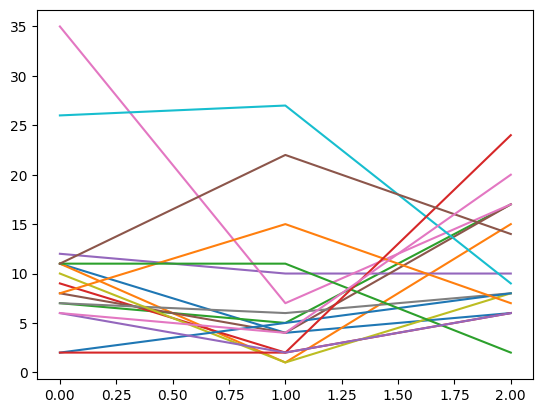

In [19]:
for subject in subject_list:

    plt.plot([np.sum(enga['speech'][subject]),np.sum(enga['music'][subject]),np.sum(enga['rest'][subject])])
    
plt.show()
plt.close()

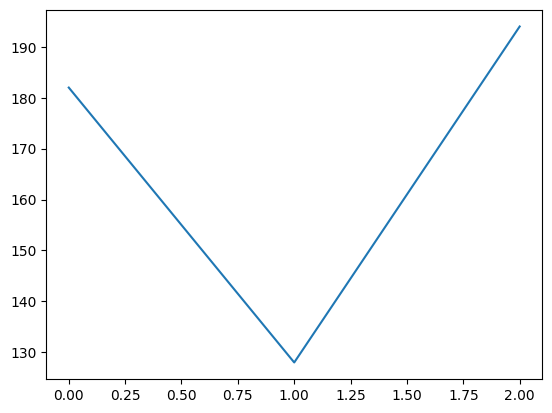

182 128 194


In [10]:
speech_eng=0
music_eng=0
rest_eng=0

for subject in subject_list:
    speech_eng+=np.sum(enga['speech'][subject])
    music_eng+=np.sum(enga['music'][subject])
    rest_eng+=np.sum(enga['rest'][subject])


plt.plot([speech_eng, music_eng, rest_eng])
plt.show()
plt.close()
print(speech_eng, music_eng, rest_eng)

speech
sub-14c725b6b803 0.06363636363636363 0.034482758620689655 110 58
sub-26176ef8a8d0 0.0625 0.16666666666666666 80 6
sub-28e70e7c7fbb 0.1717171717171717 0.2777777777777778 99 18
sub-4247d6d6cdbf 0.053763440860215055 0.0 93 15
sub-44375d501493 0.061946902654867256 0.06818181818181818 113 44
sub-45a6830d263e 0.18181818181818182 0.19791666666666666 11 96
sub-82e330f8aadd 0.058394160583941604 0.3 137 10
sub-83ebd5328120 0.042105263157894736 0.038461538461538464 95 26
sub-95a634be7e05 0.06976744186046512 0.0 129 22
sub-9d783b836f5e 0.13793103448275862 0.07692307692307693 58 65
sub-a4e7fc9daa96 0.0 0.10185185185185185 7 108
sub-c1b7ce54ce05 0.07258064516129033 0.0 124 11
sub-c2a96116ddc4 0.0 0.037037037037037035 112 27
sub-cacae171ee15 0.1717171717171717 0.23529411764705882 99 17
sub-e0bb6ccef2a5 0.09375 0.0 96 14
sub-ebf231d97f73 0.1328125 0.16666666666666666 128 18
sub-fccb4adbfadc 0.18446601941747573 0.3333333333333333 103 6
sub-14c725b6b803 0.06363636363636363 0.034482758620689655 11

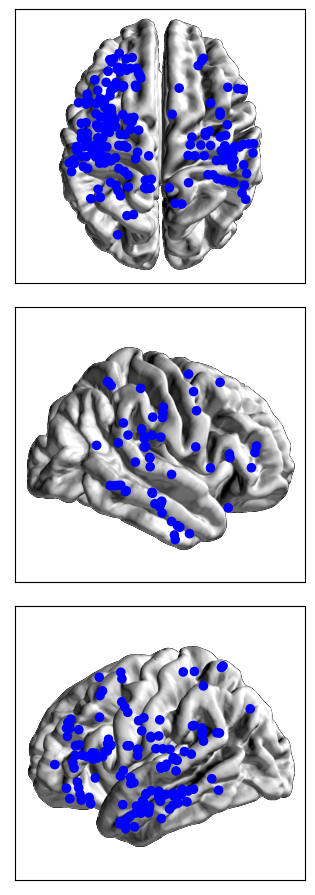

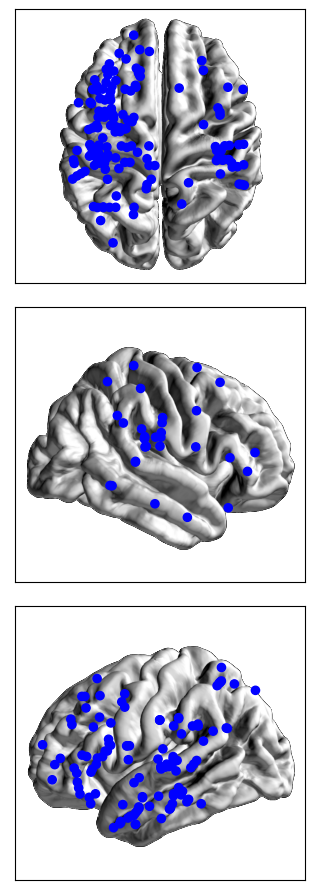

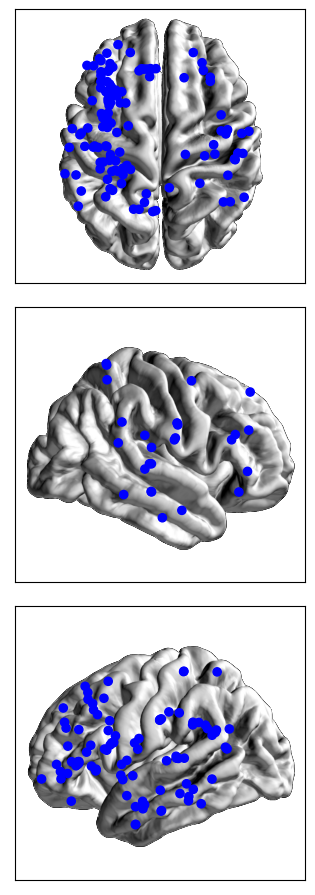

In [40]:

left_right_increase={}
right_increase={}
left_increase={}

for o, sound in enumerate(['speech','music', 'rest']):
    left_right_increase[sound]={}
    right_increase[sound]={}
    left_increase[sound]={}
        
        
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    print(sound) 
    for j,orientation in enumerate(['top','right','left']):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

            im = f[orientation]['imp'][...]
        
        axes=ax[j]

        

    
        for isub,subject in enumerate(subject_list):

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)

                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            

            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

            chnames=chnames[ch_i]

            # collect coordinates for this specific orientation (only one patient)
        

            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
            if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
                chnames = np.array([x.replace('Ip', "IP") for x in chnames])
                chnames = np.array([x.replace('p', "'") for x in chnames])
                chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     
            _, _, left_i, right_i = mp.split_hemis(chnames)

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                coordinates=f['mayavi'][orientation]['xy'][...]

            coordinates=coordinates[ch_i]

            


            per_l=np.sum(enga[sound][subject][left_i])/len(enga[sound][subject][left_i])

            per_r=np.sum(enga[sound][subject][right_i])/len(enga[sound][subject][right_i])
            

            if orientation in ('left', 'right'):

                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))

                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))



            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates


            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][left_i]))

            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][right_i]))

            if orientation =='top':
                axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject]))


            #axes.title.set_text('engagement '+sound)
            print(subject, per_l, per_r, len(enga[sound][subject][left_i]), len(enga[sound][subject][right_i]))

        axes.set_xticks([])
        axes.set_yticks([])

    plt.tight_layout(pad=0.35)
    plt.savefig(path+'figure/brain_plots_all_channels_left_right_increase'+sound+'.png', dpi=600)
            


        

speech
sub-14c725b6b803 0.045454545454545456 0.08620689655172414 110 58
sub-26176ef8a8d0 0.0625 0.3333333333333333 80 6
sub-28e70e7c7fbb 0.020202020202020204 0.0 99 18
sub-4247d6d6cdbf 0.0967741935483871 0.0 93 15
sub-44375d501493 0.07964601769911504 0.06818181818181818 113 44
sub-45a6830d263e 0.18181818181818182 0.0625 11 96
sub-82e330f8aadd 0.24817518248175183 0.0 137 10
sub-83ebd5328120 0.042105263157894736 0.0 95 26
sub-95a634be7e05 0.07751937984496124 0.0 129 22
sub-9d783b836f5e 0.13793103448275862 0.046153846153846156 58 65
sub-a4e7fc9daa96 0.0 0.018518518518518517 7 108
sub-c1b7ce54ce05 0.06451612903225806 0.0 124 11
sub-c2a96116ddc4 0.08928571428571429 0.037037037037037035 112 27
sub-cacae171ee15 0.010101010101010102 0.0 99 17
sub-e0bb6ccef2a5 0.0625 0.0 96 14
sub-ebf231d97f73 0.0390625 0.16666666666666666 128 18
sub-fccb4adbfadc 0.02912621359223301 0.0 103 6
music
sub-14c725b6b803 0.01818181818181818 0.017241379310344827 110 58
sub-26176ef8a8d0 0.0 0.0 80 6
sub-28e70e7c7fbb 0.

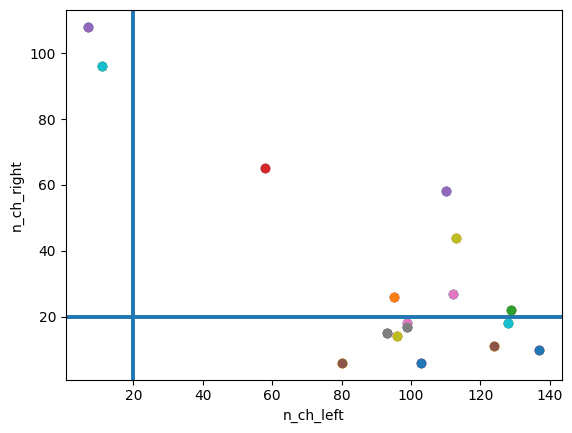

In [49]:
subject_list_corrected_left=[]
subject_list_corrected_right=[]
subject_list_corrected=[]

left_right_increase={}
right_increase={}
left_increase={}
overall_increase={}

for o, sound in enumerate(['speech','music', 'rest']):
    left_right_increase[sound]={}
    right_increase[sound]={}
    left_increase[sound]={}
    overall_increase[sound]={}
        
        
    print(sound) 
    
    for isub,subject in enumerate(subject_list):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']


        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

        ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

        chnames=chnames[ch_i]

        # collect coordinates for this specific orientation (only one patient)
       

        # make sure you only select the left electrodes for the left orientation and
        # right electrodes for the right orientation
        if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
            chnames = np.array([x.replace('Ip', "IP") for x in chnames])
            chnames = np.array([x.replace('p', "'") for x in chnames])
            chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     


        _, _, left_i, right_i = mp.split_hemis(chnames)


        per_l=np.sum(enga[sound][subject][left_i])/len(enga[sound][subject][left_i])

        per_r=np.sum(enga[sound][subject][right_i])/len(enga[sound][subject][right_i])
        
        if len(enga[sound][subject][left_i])> 20 and subject not in subject_list_corrected_left:
            subject_list_corrected_left.append(subject)
        
        if len(enga[sound][subject][right_i]) >20 and subject not in subject_list_corrected_right:
            subject_list_corrected_right.append(subject)

        if len(enga[sound][subject][right_i]) >10 and len(enga[sound][subject][left_i])> 20 and subject not in subject_list_corrected:
            subject_list_corrected.append(subject)
            
        left_right_increase[sound][subject]=per_r/per_l
        left_increase[sound][subject]=per_l
        right_increase[sound][subject]=per_r
        overall_increase[sound][subject]=np.sum(enga[sound][subject])/len(enga[sound][subject])
        
        plt.scatter( len(enga[sound][subject][left_i]), len(enga[sound][subject][right_i]))
        plt.xlabel('n_ch_left')
        plt.ylabel('n_ch_right')
        plt.axvline(20)
        plt.axhline(20)


        print(subject, per_l, per_r, len(enga[sound][subject][left_i]), len(enga[sound][subject][right_i]))
        

In [44]:
subject_list_corrected_left=[]
subject_list_corrected_right=[]
subject_list_corrected=[]

left_right_increase={}
right_increase={}
left_increase={}
overall_increase={}

for o, sound in enumerate(['speech','music', 'rest']):
    left_right_increase[sound]={}
    right_increase[sound]={}
    left_increase[sound]={}
    overall_increase[sound]={}
        
        
    print(sound) 
    
    for isub,subject in enumerate(['sub-3ef8645f99c5','sub-aea837fa1826','sub-d9c48230fb78']):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']


        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

        ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

        chnames=chnames[ch_i]

        # collect coordinates for this specific orientation (only one patient)
       

        # make sure you only select the left electrodes for the left orientation and
        # right electrodes for the right orientation
        if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
            chnames = np.array([x.replace('Ip', "IP") for x in chnames])
            chnames = np.array([x.replace('p', "'") for x in chnames])
            chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     


        _, _, left_i, right_i = mp.split_hemis(chnames)


        print(len(left_i), len(right_i))



        

speech
137 13
82 85


KeyError: "Unable to open object (object 'outlier_chans' doesn't exist)"

speech
sub-14c725b6b803 0.03636363636363636 0.06896551724137931 110 58
sub-26176ef8a8d0 0.1375 0.3333333333333333 80 6
sub-28e70e7c7fbb 0.050505050505050504 0.0 99 18
sub-4247d6d6cdbf 0.10752688172043011 0.0 93 15
sub-44375d501493 0.05309734513274336 0.045454545454545456 113 44
sub-45a6830d263e 0.18181818181818182 0.0625 11 96
sub-82e330f8aadd 0.35766423357664234 0.0 137 10
sub-83ebd5328120 0.05263157894736842 0.0 95 26
sub-95a634be7e05 0.06201550387596899 0.0 129 22
sub-9d783b836f5e 0.13793103448275862 0.06153846153846154 58 65
sub-a4e7fc9daa96 0.0 0.06481481481481481 7 108
sub-c1b7ce54ce05 0.11290322580645161 0.09090909090909091 124 11
sub-c2a96116ddc4 0.08928571428571429 0.037037037037037035 112 27
sub-cacae171ee15 0.030303030303030304 0.0 99 17
sub-e0bb6ccef2a5 0.0625 0.0 96 14
sub-ebf231d97f73 0.015625 0.0 128 18
sub-fccb4adbfadc 0.02912621359223301 0.0 103 6
music
sub-14c725b6b803 0.02727272727272727 0.017241379310344827 110 58
sub-26176ef8a8d0 0.0125 0.0 80 6
sub-28e70e7c7fbb 0.

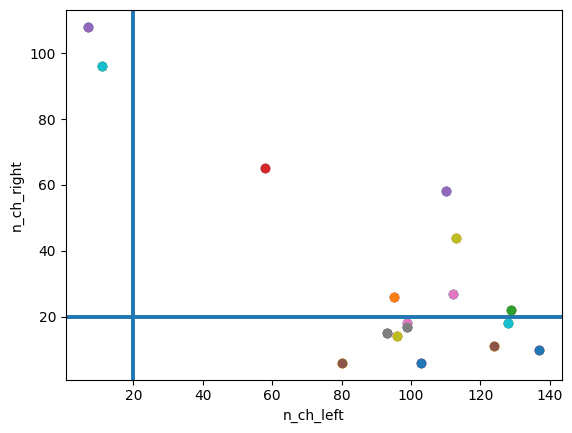

In [ ]:


for o, sound in enumerate(['speech','music', 'rest']):    
    print(sound) 
    for isub,subject in enumerate(subject_list):
        
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        

        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

        ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

        chnames=chnames[ch_i]

        # collect coordinates for this specific orientation (only one patient)
       

        # make sure you only select the left electrodes for the left orientation and
        # right electrodes for the right orientation
        if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
            chnames = np.array([x.replace('Ip', "IP") for x in chnames])
            chnames = np.array([x.replace('p', "'") for x in chnames])
            chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     


        _, _, left_i, right_i = mp.split_hemis(chnames)


        per_l=np.sum(enga[sound][subject][left_i])/len(enga[sound][subject][left_i])

        per_r=np.sum(enga[sound][subject][right_i])/len(enga[sound][subject][right_i])
        
        if len(enga[sound][subject][left_i])> 20 and subject not in subject_list_corrected_left:
            subject_list_corrected_left.append(subject)
        
        if len(enga[sound][subject][right_i]) >20 and subject not in subject_list_corrected_right:
            subject_list_corrected_right.append(subject)

        if len(enga[sound][subject][right_i]) >10 and len(enga[sound][subject][left_i])> 20 and subject not in subject_list_corrected:
            subject_list_corrected.append(subject)
            
        left_right_increase[sound][subject]=per_r/per_l
        left_increase[sound][subject]=per_l
        right_increase[sound][subject]=per_r
        overall_increase[sound][subject]=np.sum(enga[sound][subject])/len(enga[sound][subject])
        
        plt.scatter( len(enga[sound][subject][left_i]), len(enga[sound][subject][right_i]))
        plt.xlabel('n_ch_left')
        plt.ylabel('n_ch_right')
        plt.axvline(20)
        plt.axhline(20)


        print(subject, per_l, per_r, len(enga[sound][subject][left_i]), len(enga[sound][subject][right_i]))
        

WilcoxonResult(statistic=41.0, pvalue=0.0983734130859375)
Gio test   0.006999300069993001


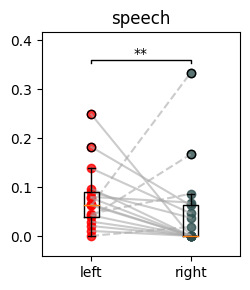

WilcoxonResult(statistic=56.0, pvalue=0.5348569507731826)
Gio test   0.025097490250974904


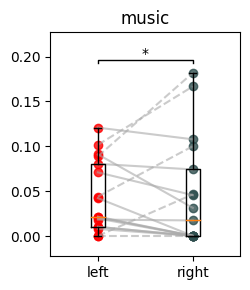

WilcoxonResult(statistic=51.0, pvalue=0.243499755859375)
Gio test   0.16918308169183083


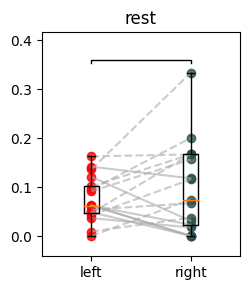

In [50]:
left_increase_list={}
right_increase_list={}
overall_increase_list={}
C0= ['r', 'darkslategrey', 'r', 'c', 'm', 'y', 'k', 'w']
C1={'s':'#93cb90', 'm':'#ffa96b', 'r':'#6da3cc'}
#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)
for sound in sound_list:
    plt.figure(figsize=(2.4,2.8))
    plt.title(sound)
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    overall_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
        overall_increase_list[sound].append(overall_increase[sound][subject])
    
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    overall_increase_list[sound]=np.array(overall_increase_list[sound])
    
    box_plot_data=[left_increase_list[sound],right_increase_list[sound]]
    for i in range(len(right_increase_list[sound])):
        pr=left_increase_list[sound][i]
        ps=right_increase_list[sound][i]
        plt.scatter(1,pr,color=C0[0],alpha=0.8)
        plt.scatter(2,ps,color=C0[1],alpha=0.8)
        if pr-ps>0:
            plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6)
        else:
            plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6,linestyle='--')
    
    plt.boxplot(box_plot_data,patch_artist=False,labels=['left','right'])
    pp=stats.wilcoxon(left_increase_list[sound],right_increase_list[sound])[1]
    p=Gtest(left_increase_list[sound],right_increase_list[sound],N=10001)
    print(stats.wilcoxon(left_increase_list[sound],right_increase_list[sound]))
    print('Gio test  ', p)
    bottom, top = np.min([left_increase_list[sound],right_increase_list[sound]]),np.max([left_increase_list[sound],right_increase_list[sound]])
    bars(p, bottom, top)   
    plt.tight_layout(pad=0.35)
    plt.savefig('eng_increase_'+sound+'.pdf', dpi=600)
    plt.show()
    plt.close()
    

Gio test   0.0694
WilcoxonResult(statistic=32.0, pvalue=0.11176874513967607)
p_value music - speech  0.11176874513967607
p_value music - rest  0.352874755859375
p_value music - rest  0.07873081119613402


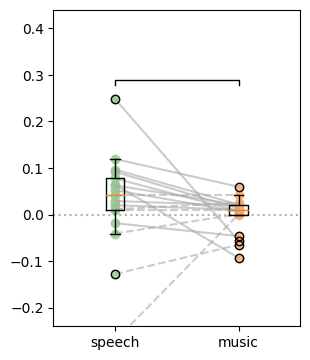

In [51]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in range(len(right_increase_list['speech'])):
    ps=left_increase_list['speech'][i]-right_increase_list['speech'][i]
    pm=left_increase_list['music'][i]-right_increase_list['music'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    
    if ps-pm>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
pp=stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])[1]
pmr=stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['rest']-right_increase_list['rest'])[1]
psr=stats.wilcoxon(left_increase_list['rest']-right_increase_list['rest'],left_increase_list['music']-right_increase_list['music'])[1]

p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
print('Gio test  ', p)
print(stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value music - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
plt.show()
plt.close()
    

Gio test   0.1528
Wilcoxon test
p_value speech - music  0.0395355224609375
p_value speech - rest  0.19144640357050802
p_value music - rest  0.644134521484375


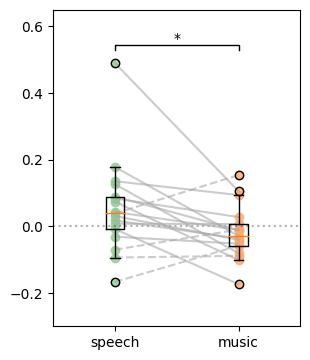

In [60]:
plt.figure(figsize=(2.4*1.25,2.8*1.25))
# plt.title('left-right greater than expected')

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech']-right_increase_list['speech']-(left_decrease_list['speech']-right_decrease_list['speech']),left_increase_list['music']-right_increase_list['music']-(left_decrease_list['music']-right_decrease_list['music'])]

for i in range(len(right_decrease_list['speech'])):
    
    ps=left_increase_list['speech'][i]-right_increase_list['speech'][i]-(left_decrease_list['speech'][i]-right_decrease_list['speech'][i])
    pm=left_increase_list['music'][i]-right_increase_list['music'][i]-(left_decrease_list['music'][i]-right_decrease_list['music'][i])

    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    
    if ps-pm>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
pp=stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech']-(left_decrease_list['speech']-right_decrease_list['speech']),left_increase_list['music']-right_increase_list['music']-(left_decrease_list['music']-right_decrease_list['music']))[1]
pmr=stats.wilcoxon(left_decrease_list['rest']-right_decrease_list['rest'],left_decrease_list['music']-right_decrease_list['music'])[1]
psr=stats.wilcoxon(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['rest']-right_decrease_list['rest'])[1]

p=Gtest(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'])
print('Gio test  ', p)
print('Wilcoxon test')
print('p_value speech - music ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_increase_list['speech']-right_increase_list['speech']-(left_decrease_list['speech']-right_decrease_list['speech']),left_increase_list['music']-right_increase_list['music']-(left_decrease_list['music']-right_decrease_list['music'])])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(pp, bottom, top)
plt.ylim((-0.3,0.65))
plt.tight_layout(pad=0.35)
plt.savefig('left-right_decrease_with_rest.pdf', dpi=600)
plt.show()
plt.close()

In [61]:
C1

{'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}

In [ ]:
coord={}
for n, i in enumerate(np.linspace(0,np.pi*2, 10)[:-1]):
    coord[list_rois[n]]=(np.cos(i), np.sin(i))


In [ ]:
coord={}
for n, i in enumerate(np.linspace(0,np.pi*2, 10)[:-1]):
    coord[list_rois[n]]=(np.cos(i), np.sin(i))


In [152]:
len(subject_list)

17

NameError: name 'C1' is not defined

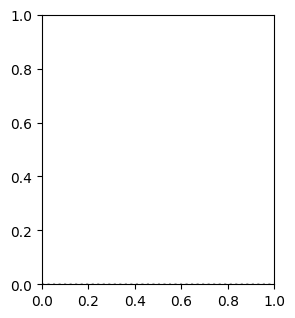

In [20]:

    
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])  
plt.figure(figsize=(2.4*1.25,2.8*1.25))

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in range(len(right_increase_list['speech'])):
    pr=left_increase_list['speech'][i]-right_increase_list['speech'][i]
    ps=left_increase_list['music'][i]-right_increase_list['music'][i]
    plt.scatter(1,pr,color=C1['s'],alpha=.8)
    plt.scatter(2,ps,color=C1['m'],alpha=.8)
    
    if pr-ps>0:
        plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
pp=stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])[1]
p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
to_min=np.array([left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left-right_increase.pdf', dpi=600)
plt.show()
plt.close()
    

NameError: name 'left_decrease_list' is not defined

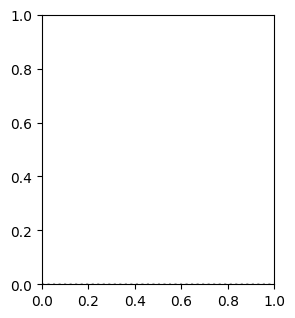

In [25]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in range(len(left_increase_list['speech'])):
    pr=left_increase_list['speech'][i]-left_increase_list['speech'][i]
    ps=left_increase_list['music'][i]-left_increase_list['music'][i]
    plt.scatter(1,pr,color=C1['s'],alpha=.8)
    plt.scatter(2,ps,color=C1['m'],alpha=.8)
    
    if pr-ps>0:
        plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
pp=stats.mannwhitneyu(left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music'])[1]
p=Gtest(left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music']))
to_min=np.array([left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left-right_increase.pdf', dpi=600)
plt.show()
plt.close()
    

NameError: name 'right_decrease_list' is not defined

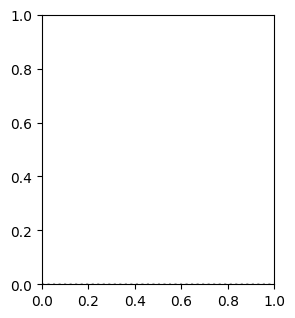

In [16]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[right_increase_list['speech']-right_decrease_list['speech'],right_increase_list['music']-right_decrease_list['music'],right_increase_list['rest']-right_decrease_list['rest']]
count=0
for i in range(len(right_decrease_list['speech'])):

    ps=right_increase_list['speech'][i]-right_decrease_list['speech'][i]
    pm=right_increase_list['music'][i]-right_decrease_list['music'][i]
    pr=right_increase_list['rest'][i]-right_decrease_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(right_increase_list['speech']-right_decrease_list['speech'],right_increase_list['music']-right_decrease_list['music'])[1]
p=Gtest(right_increase_list['speech']-right_decrease_list['speech'],right_increase_list['music']-right_decrease_list['music'])
print('Gio test  ', p)
print('speech - music  ',stats.mannwhitneyu(right_increase_list['speech']-right_decrease_list['speech'],right_increase_list['music']-left_decrease_list['music']))
print('speech - rest  ', stats.mannwhitneyu(right_increase_list['speech']-right_decrease_list['speech'],right_increase_list['rest']-left_decrease_list['rest']))
print('music - rest  ', stats.mannwhitneyu(right_increase_list['music']-right_decrease_list['music'],right_increase_list['rest']-left_decrease_list['rest']))
to_min=np.array([right_increase_list['speech']-right_decrease_list['speech'],right_increase_list['music']-right_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.ylim((-0.6,0.5))
plt.savefig('right_in-decrease.png', dpi=600)
plt.show()
plt.close()
    

In [ ]:
count

13

Gio test   0.1578
speech - music   MannwhitneyuResult(statistic=157.0, pvalue=0.6792778685775764)
speech - rest   MannwhitneyuResult(statistic=105.0, pvalue=0.1785106631557255)
music - rest   MannwhitneyuResult(statistic=90.5, pvalue=0.06516298537746669)


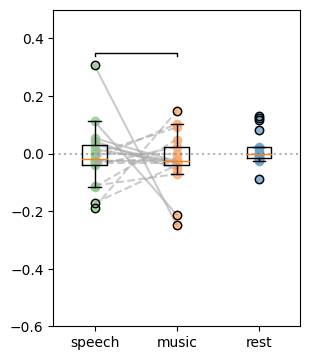

In [118]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
count=0
box_plot_data=[left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music'],left_increase_list['rest']-left_decrease_list['rest']]
for i in range(len(right_decrease_list['speech'])):
    ps=left_increase_list['speech'][i]-left_decrease_list['speech'][i]
    pm=left_increase_list['music'][i]-left_decrease_list['music'][i]
    pr=left_increase_list['rest'][i]-left_decrease_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music'])[1]
p=Gtest(left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music'])
print('Gio test  ', p)
print('speech - music  ',stats.mannwhitneyu(left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music']))
print('speech - rest  ', stats.mannwhitneyu(left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['rest']-left_decrease_list['rest']))
print('music - rest  ', stats.mannwhitneyu(left_increase_list['music']-left_decrease_list['music'],left_increase_list['rest']-left_decrease_list['rest']))
to_min=np.array([left_increase_list['speech']-left_decrease_list['speech'],left_increase_list['music']-left_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.ylim((-0.6,0.5))
plt.savefig('left_in-decrease.png', dpi=600)
plt.show()
plt.close()
    

In [119]:
count

7

Gio test   0.0764
MannwhitneyuResult(statistic=204.5, pvalue=0.04034751181619099)
p_value music - speech  0.04034751181619099
p_value music - rest  0.4694529442341775
p_value music - rest  0.05162973029251238


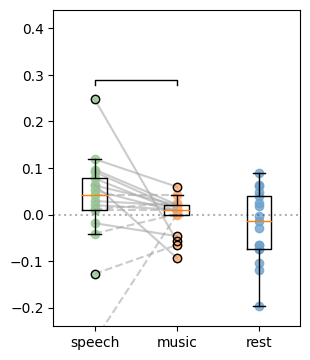

In [26]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'], left_increase_list['rest']-right_increase_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=left_increase_list['speech'][i]-right_increase_list['speech'][i]
    pm=left_increase_list['music'][i]-right_increase_list['music'][i]
    pr=left_increase_list['rest'][i]-right_increase_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])[1]
pmr=stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['rest']-right_increase_list['rest'])[1]
psr=stats.mannwhitneyu(left_increase_list['rest']-right_increase_list['rest'],left_increase_list['music']-right_increase_list['music'])[1]

p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value music - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
plt.show()
plt.close()
    

Gio test   0.0682
MannwhitneyuResult(statistic=204.5, pvalue=0.04034751181619099)
p_value music - speech  0.04034751181619099
p_value music - rest  0.4694529442341775
p_value music - rest  0.05162973029251238


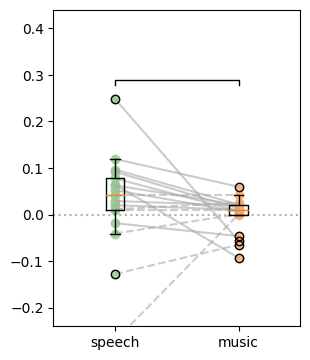

In [28]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in range(len(right_increase_list['speech'])):
    ps=left_increase_list['speech'][i]-right_increase_list['speech'][i]
    pm=left_increase_list['music'][i]-right_increase_list['music'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    
    if ps-pm>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
pp=stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])[1]
pmr=stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['rest']-right_increase_list['rest'])[1]
psr=stats.mannwhitneyu(left_increase_list['rest']-right_increase_list['rest'],left_increase_list['music']-right_increase_list['music'])[1]

p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value music - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left-right_increase_with_rest.pdf', dpi=600)
plt.show()
plt.close()
    

numero trend expected  12 su 17
Gio test   0.0262
MannwhitneyuResult(statistic=176.0, pvalue=0.28559671980842016)
p_value music - speech  0.28559671980842016
p_value speech - rest  0.8362374630036167
p_value music - rest  0.26292675609481375


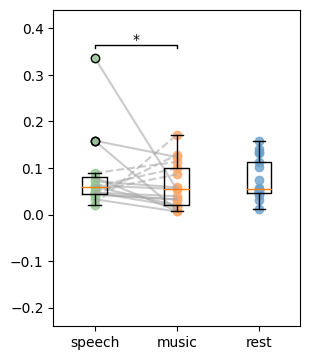

In [95]:

    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

count=0
#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[overall_increase_list['speech'],overall_increase_list['music'], overall_increase_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=overall_increase_list['speech'][i]
    pm=overall_increase_list['music'][i]
    pr=overall_increase_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(overall_increase_list['speech'],overall_increase_list['music'])[1]
psr=stats.mannwhitneyu(overall_increase_list['speech'],overall_increase_list['rest'])[1]
pmr=stats.mannwhitneyu(overall_increase_list['rest'],overall_increase_list['music'])[1]
print("numero trend expected ", str(count)+' su 17')
p=Gtest(overall_increase_list['speech'],overall_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(overall_increase_list['speech'],overall_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([overall_increase_list['speech'],overall_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('overall_increase_across_conditions.png', dpi=600)
plt.show()
plt.close()
    

numero trend expected  12 su 17
Gio test   0.0244
MannwhitneyuResult(statistic=185.0, pvalue=0.16821816079586904)
p_value music - speech  0.16821816079586904
p_value speech - rest  1.0
p_value music - rest  0.2279301564822106


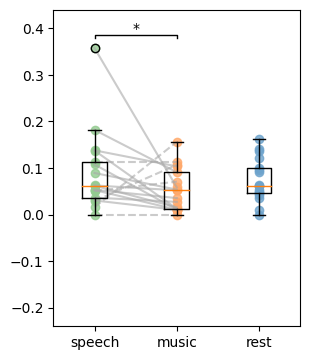

In [ ]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

count=0
#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech'],left_increase_list['music'], left_increase_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=left_increase_list['speech'][i]
    pm=left_increase_list['music'][i]
    pr=left_increase_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(left_increase_list['speech'],left_increase_list['music'])[1]
psr=stats.mannwhitneyu(left_increase_list['speech'],left_increase_list['rest'])[1]
pmr=stats.mannwhitneyu(left_increase_list['rest'],left_increase_list['music'])[1]
print("numero trend expected ", str(count)+' su 17')
p=Gtest(left_increase_list['speech'],left_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(left_increase_list['speech'],left_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_increase_list['speech'],left_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left_increase_across_conditions.png', dpi=600)
plt.show()
plt.close()
    

numero trend expected  14 su 17
Gio test   0.0018
MannwhitneyuResult(statistic=99.0, pvalue=0.10792085030041286)
p_value music - speech  0.10792085030041286
p_value speech - rest  0.02763631088782732
p_value music - rest  0.6395767891949813


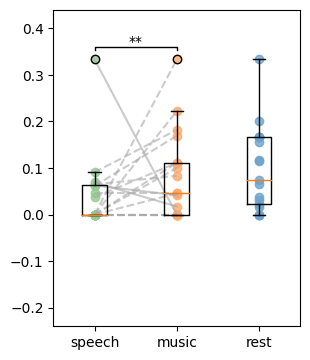

In [52]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

count=0
#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[right_increase_list['speech'],right_increase_list['music'], right_increase_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=right_increase_list['speech'][i]
    pm=right_increase_list['music'][i]
    pr=right_increase_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(right_increase_list['speech'],right_increase_list['music'])[1]
psr=stats.mannwhitneyu(right_increase_list['speech'],right_increase_list['rest'])[1]
pmr=stats.mannwhitneyu(right_increase_list['rest'],right_increase_list['music'])[1]
print("numero trend expected ", str(count)+' su 17')
p=Gtest(right_increase_list['speech'],right_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(right_increase_list['speech'],right_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([right_increase_list['speech'],right_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('right_increase_across_conditions.png', dpi=600)
plt.show()
plt.close()
    

Gio test   0.0264
MannwhitneyuResult(statistic=185.0, pvalue=0.16821816079586904)
p_value music - speech  0.16821816079586904
p_value music - rest  0.2279301564822106
p_value music - rest  1.0


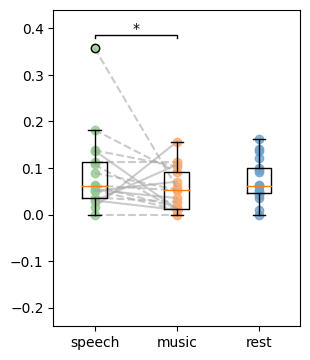

In [ ]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_increase_list['speech'],left_increase_list['music'], left_increase_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=left_increase_list['speech'][i]
    pm=left_increase_list['music'][i]
    pr=left_increase_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if pr-ps>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(left_increase_list['speech'],left_increase_list['music'])[1]
pmr=stats.mannwhitneyu(left_increase_list['speech'],left_increase_list['rest'])[1]
psr=stats.mannwhitneyu(left_increase_list['rest'],left_increase_list['music'])[1]

p=Gtest(left_increase_list['speech'],left_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(left_increase_list['speech'],left_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value music - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_increase_list['speech'],left_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left_increase_across_conditions.pdf', dpi=600)
plt.show()
plt.close()
    

In [1]:
left_increase_list={}
right_increase_list={}

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)

for sound in sound_list:
    left_increase_list[sound]=[]
    right_increase_list[sound]=[]
    for subject in subject_list:
        left_increase_list[sound].append(left_increase[sound][subject])
        right_increase_list[sound].append(right_increase[sound][subject])
    left_increase_list[sound]=np.array(left_increase_list[sound])
    right_increase_list[sound]=np.array(right_increase_list[sound])
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[right_increase_list['speech'],right_increase_list['music'], right_increase_list['rest']]
count=0
for i in range(len(right_increase_list['speech'])):
    ps=right_increase_list['speech'][i]
    pm=right_increase_list['music'][i]
    pr=right_increase_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(right_increase_list['speech'],right_increase_list['music'])[1]
pmr=stats.mannwhitneyu(right_increase_list['speech'],right_increase_list['rest'])[1]
psr=stats.mannwhitneyu(right_increase_list['rest'],right_increase_list['music'])[1]

p=Gtest(right_increase_list['speech'],right_increase_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(right_increase_list['speech'],right_increase_list['music']))
print('p_value music - speech ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([right_increase_list['speech'],right_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('right_increase_across_conditions.pdf', dpi=600)
plt.show()
plt.close()
    

NameError: name 'sound_list' is not defined

3

In [29]:
enga={}

for sound in sound_list:
    enga[sound]={}
    
for subject in subject_list:
    pvalue=1
    enga['music'][subject]=np.where(sig_dict[subject]['p_mr']==pvalue,1,0)
    enga['rest'][subject]=np.where(sig_dict[subject]['p_r']==pvalue,1,0)
    enga['speech'][subject]=np.where(sig_dict[subject]['p_sr']==pvalue,1,0)
    
    

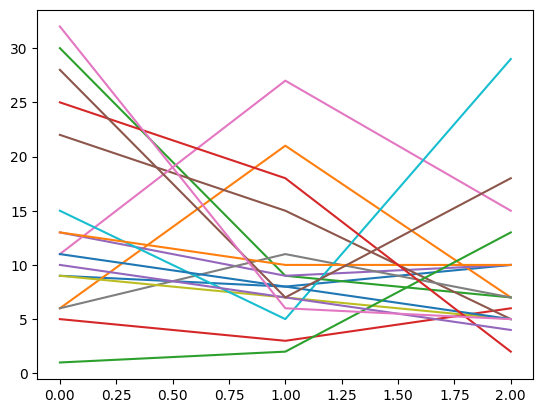

In [30]:
for subject in subject_list:
    plt.plot([np.sum(enga['speech'][subject]),np.sum(enga['music'][subject]),np.sum(enga['rest'][subject])])
plt.show()
plt.close()

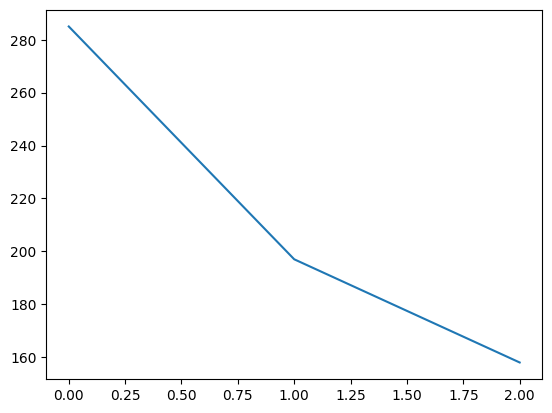

285 197 158


In [86]:
speech_eng=0
music_eng=0
rest_eng=0

for subject in subject_list:
    speech_eng+=np.sum(enga['speech'][subject])
    music_eng+=np.sum(enga['music'][subject])

    rest_eng+=np.sum(enga['rest'][subject])


plt.plot([speech_eng, music_eng, rest_eng])
plt.show()
plt.close()

print(speech_eng, music_eng, rest_eng)

speech
sub-14c725b6b803 0.06363636363636363 0.05172413793103448 110 58
sub-26176ef8a8d0 0.025 0.0 80 6
sub-28e70e7c7fbb 0.2222222222222222 0.3888888888888889 99 18
sub-4247d6d6cdbf 0.06451612903225806 0.0 93 15
sub-44375d501493 0.07964601769911504 0.06818181818181818 113 44
sub-45a6830d263e 0.18181818181818182 0.1875 11 96
sub-82e330f8aadd 0.051094890510948905 0.1 137 10
sub-83ebd5328120 0.021052631578947368 0.07692307692307693 95 26
sub-95a634be7e05 0.046511627906976744 0.045454545454545456 129 22
sub-9d783b836f5e 0.15517241379310345 0.15384615384615385 58 65
sub-a4e7fc9daa96 0.0 0.16666666666666666 7 108
sub-c1b7ce54ce05 0.1532258064516129 0.09090909090909091 124 11
sub-c2a96116ddc4 0.03571428571428571 0.1111111111111111 112 27
sub-cacae171ee15 0.1414141414141414 0.11764705882352941 99 17
sub-e0bb6ccef2a5 0.09375 0.0 96 14
sub-ebf231d97f73 0.203125 0.3333333333333333 128 18
sub-fccb4adbfadc 0.14563106796116504 0.3333333333333333 103 6
sub-14c725b6b803 0.06363636363636363 0.0517241379

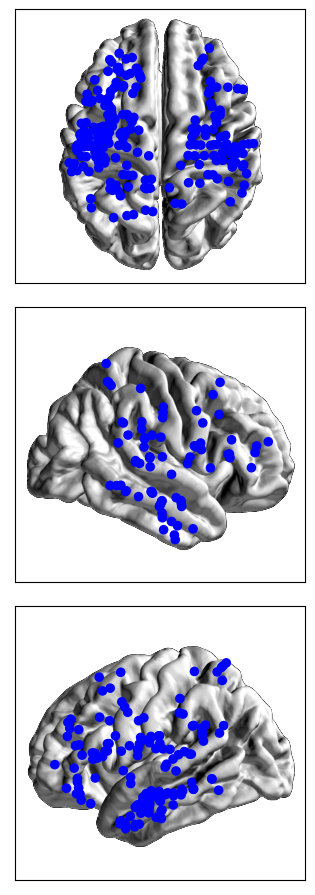

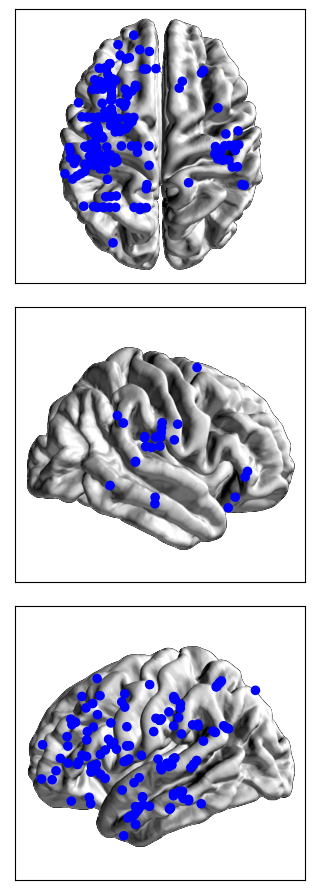

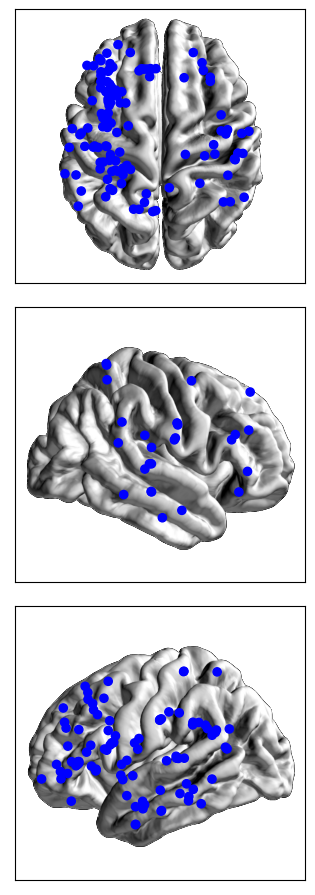

In [14]:
for o, sound in enumerate(['speech','music', 'rest']):
    left_right_increase[sound]={}
    right_increase[sound]={}
    left_increase[sound]={}
    overall_increase[sound]={}

        
        
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    print(sound) 
    for j,orientation in enumerate(['top','right','left']):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

            im = f[orientation]['imp'][...]
        
        axes=ax[j]

        

    
        for isub,subject in enumerate(subject_list):

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)

                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            

            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

            chnames=chnames[ch_i]

            # collect coordinates for this specific orientation (only one patient)
        

            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
            if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
                chnames = np.array([x.replace('Ip', "IP") for x in chnames])
                chnames = np.array([x.replace('p', "'") for x in chnames])
                chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                coordinates=f['mayavi'][orientation]['xy'][...]

            coordinates=coordinates[ch_i]

            _, _, left_i, right_i = mp.split_hemis(chnames)


            per_l=np.sum(enga[sound][subject][left_i])/len(enga[sound][subject][left_i])

            per_r=np.sum(enga[sound][subject][right_i])/len(enga[sound][subject][right_i])
            

            if orientation in ('left', 'right'):

                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))

                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))



            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates


            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][left_i]))

            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][right_i]))

            if orientation =='top':
                axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject]))


            #axes.title.set_text('engagement '+sound)
            print(subject, per_l, per_r, len(enga[sound][subject][left_i]), len(enga[sound][subject][right_i]))

        axes.set_xticks([])
        axes.set_yticks([])

    plt.tight_layout(pad=0.35)
    plt.savefig(path+'figure/brain_plots_all_channels_left_right_increase'+sound+'.png', dpi=600)
            


        

In [31]:

left_right_decrease={}
right_decrease={}
left_decrease={}
overall_decrease={}

for o, sound in enumerate(['speech','music', 'rest']):
    left_right_decrease[sound]={}
    right_decrease[sound]={}
    left_decrease[sound]={}
    overall_decrease[sound]={}
        
        
    print(sound) 
    
    for isub,subject in enumerate(subject_list):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']


        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

        ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

        chnames=chnames[ch_i]

        # collect coordinates for this specific orientation (only one patient)
        


        # make sure you only select the left electrodes for the left orientation and
        # right electrodes for the right orientation
        if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
            chnames = np.array([x.replace('Ip', "IP") for x in chnames])
            chnames = np.array([x.replace('p', "'") for x in chnames])
            chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     


        _, _, left_i, right_i = mp.split_hemis(chnames)


        per_l=np.sum(enga[sound][subject][left_i])/len(enga[sound][subject][left_i])

        per_r=np.sum(enga[sound][subject][right_i])/len(enga[sound][subject][right_i])
        
        overall_decrease[sound][subject]=np.sum(enga[sound][subject])/len(enga[sound][subject])
            
        left_right_decrease[sound][subject]=per_r/per_l
        left_decrease[sound][subject]=per_l
        right_decrease[sound][subject]=per_r
        print(subject, per_l, per_r)
        

speech
sub-14c725b6b803 0.06363636363636363 0.034482758620689655
sub-26176ef8a8d0 0.0625 0.16666666666666666
sub-28e70e7c7fbb 0.1717171717171717 0.2777777777777778
sub-4247d6d6cdbf 0.053763440860215055 0.0
sub-44375d501493 0.061946902654867256 0.06818181818181818
sub-45a6830d263e 0.18181818181818182 0.19791666666666666
sub-82e330f8aadd 0.058394160583941604 0.3
sub-83ebd5328120 0.042105263157894736 0.038461538461538464
sub-95a634be7e05 0.06976744186046512 0.0
sub-9d783b836f5e 0.13793103448275862 0.07692307692307693
sub-a4e7fc9daa96 0.0 0.10185185185185185
sub-c1b7ce54ce05 0.07258064516129033 0.0
sub-c2a96116ddc4 0.0 0.037037037037037035
sub-cacae171ee15 0.1717171717171717 0.23529411764705882
sub-e0bb6ccef2a5 0.09375 0.0
sub-ebf231d97f73 0.1328125 0.16666666666666666
sub-fccb4adbfadc 0.18446601941747573 0.3333333333333333
music
sub-14c725b6b803 0.045454545454545456 0.034482758620689655
sub-26176ef8a8d0 0.225 0.16666666666666666
sub-28e70e7c7fbb 0.09090909090909091 0.0
sub-4247d6d6cdbf 0.

speech
sub-14c725b6b803 0.06363636363636363 0.034482758620689655 110 58
sub-26176ef8a8d0 0.0625 0.16666666666666666 80 6
sub-28e70e7c7fbb 0.1717171717171717 0.2777777777777778 99 18
sub-4247d6d6cdbf 0.053763440860215055 0.0 93 15
sub-44375d501493 0.061946902654867256 0.06818181818181818 113 44
sub-45a6830d263e 0.18181818181818182 0.19791666666666666 11 96
sub-82e330f8aadd 0.058394160583941604 0.3 137 10
sub-83ebd5328120 0.042105263157894736 0.038461538461538464 95 26
sub-95a634be7e05 0.06976744186046512 0.0 129 22
sub-9d783b836f5e 0.13793103448275862 0.07692307692307693 58 65
sub-a4e7fc9daa96 0.0 0.10185185185185185 7 108
sub-c1b7ce54ce05 0.07258064516129033 0.0 124 11
sub-c2a96116ddc4 0.0 0.037037037037037035 112 27
sub-cacae171ee15 0.1717171717171717 0.23529411764705882 99 17
sub-e0bb6ccef2a5 0.09375 0.0 96 14
sub-ebf231d97f73 0.1328125 0.16666666666666666 128 18
sub-fccb4adbfadc 0.18446601941747573 0.3333333333333333 103 6
sub-14c725b6b803 0.06363636363636363 0.034482758620689655 11

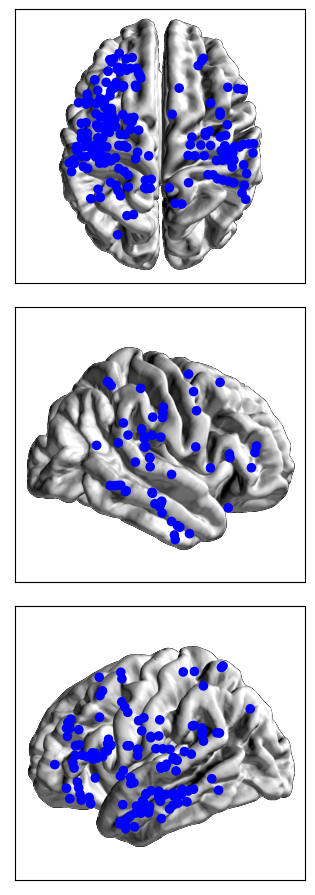

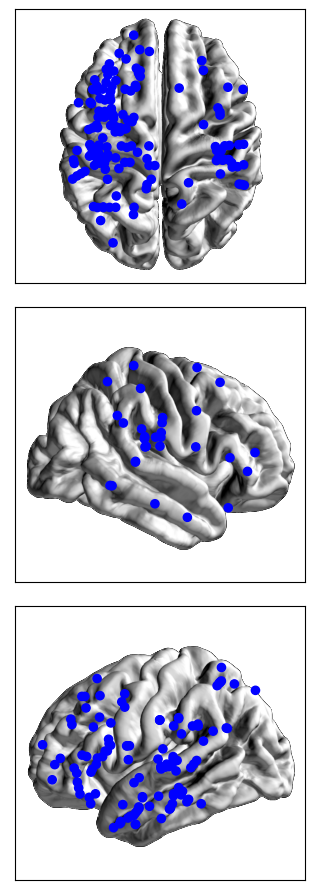

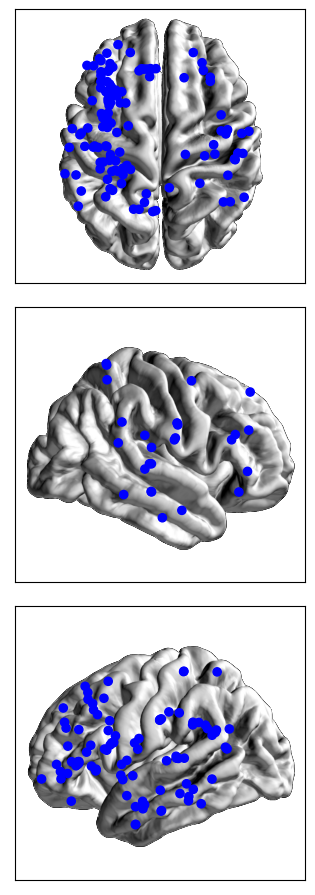

In [38]:
for o, sound in enumerate(['speech','music', 'rest']):
    
        
        
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    print(sound) 
    for j,orientation in enumerate(['top','right','left']):

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

            im = f[orientation]['imp'][...]
        
        axes=ax[j]

        

    
        for isub,subject in enumerate(subject_list):

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)

                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            

            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

            chnames=chnames[ch_i]

            # collect coordinates for this specific orientation (only one patient)
        

            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
            if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
                chnames = np.array([x.replace('Ip', "IP") for x in chnames])
                chnames = np.array([x.replace('p', "'") for x in chnames])
                chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                coordinates=f['mayavi'][orientation]['xy'][...]

            coordinates=coordinates[ch_i]

            _, _, left_i, right_i = mp.split_hemis(chnames)


            per_l=np.sum(enga[sound][subject][left_i])/len(enga[sound][subject][left_i])

            per_r=np.sum(enga[sound][subject][right_i])/len(enga[sound][subject][right_i])
            

            if orientation in ('left', 'right'):

                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))

                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))



            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates


            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][left_i]))

            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][right_i]))

            if orientation =='top':
                axes.scatter(*x_h.T, color='b', s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject]))


            #axes.title.set_text('engagement '+sound)
            print(subject, per_l, per_r, len(enga[sound][subject][left_i]), len(enga[sound][subject][right_i]))

        axes.set_xticks([])
        axes.set_yticks([])

    plt.tight_layout(pad=0.35)
    plt.savefig(path+'figure/brain_plots_all_channels_left_right_decrease'+sound+'.png', dpi=600)
            


        

WilcoxonResult(statistic=53.0, pvalue=0.2841644287109375)


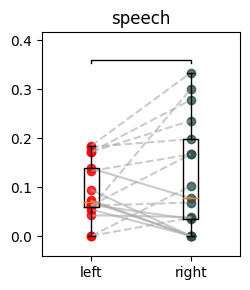

WilcoxonResult(statistic=51.0, pvalue=0.243499755859375)


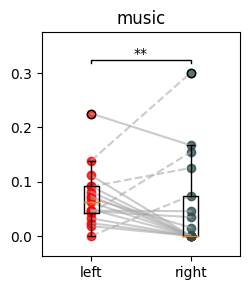

WilcoxonResult(statistic=51.0, pvalue=0.243499755859375)


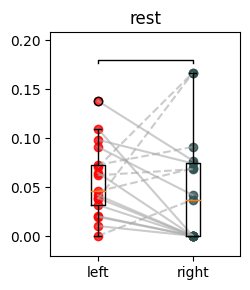

In [37]:
left_decrease_list={}
right_decrease_list={}
overall_decrease_list={}
C0= ['r', 'darkslategrey', 'r', 'c', 'm', 'y', 'k', 'w']

#plt.figure(figsize=(9,3))
#plt.suptitle("Mean Coordination - Subcortical voxels",fontsize=14)
#plt.subplot(1,3,1)
for sound in sound_list:
    plt.figure(figsize=(2.4,2.8))
    plt.title(sound)
    left_decrease_list[sound]=[]
    right_decrease_list[sound]=[]
    overall_decrease_list[sound]=[]
    for subject in subject_list:
        left_decrease_list[sound].append(left_decrease[sound][subject])
        right_decrease_list[sound].append(right_decrease[sound][subject])
        overall_decrease_list[sound].append(overall_decrease[sound][subject])
    
    right_decrease_list[sound]=np.array(right_decrease_list[sound])
    left_decrease_list[sound]=np.array(left_decrease_list[sound])
    overall_decrease_list[sound]=np.array(overall_decrease_list[sound])
    
    box_plot_data=[left_decrease_list[sound],right_decrease_list[sound]]
    for i in range(len(right_decrease_list[sound])):
        pr=left_decrease_list[sound][i]
        ps=right_decrease_list[sound][i]
        plt.scatter(1,pr,color=C0[0],alpha=0.8)
        plt.scatter(2,ps,color=C0[1],alpha=0.8)
        if pr-ps>0:
            plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6)
        else:
            plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6,linestyle='--')
    
    plt.boxplot(box_plot_data,patch_artist=False,labels=['left','right'])
    pp=stats.wilcoxon(left_decrease_list[sound],right_decrease_list[sound])[1]
    p=Gtest(left_decrease_list[sound],right_decrease_list[sound], N=10000)
    print(stats.wilcoxon(left_decrease_list[sound],right_decrease_list[sound]))
    bottom, top = np.min([left_decrease_list[sound],right_decrease_list[sound]]),np.max([left_decrease_list[sound],right_decrease_list[sound]])
    bars(p, bottom, top) 
    plt.tight_layout(pad=0.35)
    plt.savefig('eng_decrease_'+sound+'.pdf', dpi=600)
    plt.show()
    plt.close()
    

Gio test   0.175
Wilcoxon test
p_value speech - music  0.120208740234375
p_value speech - rest  0.19144640357050802
p_value music - rest  0.644134521484375


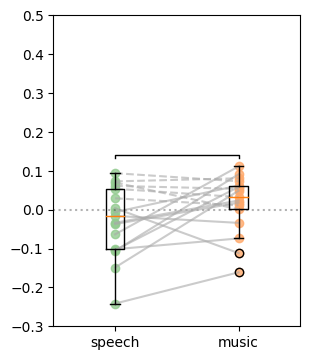

In [ ]:
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))
# plt.title('left-right greater than expected')

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music']]

for i in range(len(right_decrease_list['speech'])):
    
    ps=left_decrease_list['speech'][i]-right_decrease_list['speech'][i]
    pm=left_decrease_list['music'][i]-right_decrease_list['music'][i]

    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    
    if pr-ps>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
pp=stats.wilcoxon(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'])[1]
pmr=stats.wilcoxon(left_decrease_list['rest']-right_decrease_list['rest'],left_decrease_list['music']-right_decrease_list['music'])[1]
psr=stats.wilcoxon(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['rest']-right_decrease_list['rest'])[1]

p=Gtest(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'])
print('Gio test  ', p)
print('Wilcoxon test')
print('p_value speech - music ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.ylim((-0.3,0.5))
plt.tight_layout(pad=0.35)
plt.savefig('left-right_decrease_with_rest.pdf', dpi=600)
plt.show()
plt.close()
    

numero trend expected  11 su 17
Gio test   0.0662
MannwhitneyuResult(statistic=181.0, pvalue=0.21491745984204358)
p_value music - speech  0.21491745984204358
p_value speech - rest  0.035593841113190285
p_value music - rest  0.3262029809617468


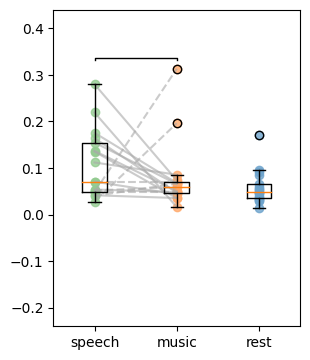

In [88]:

    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

count=0
#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[overall_decrease_list['speech'],overall_decrease_list['music'], overall_decrease_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=overall_decrease_list['speech'][i]
    pm=overall_decrease_list['music'][i]
    pr=overall_decrease_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(overall_decrease_list['speech'],overall_decrease_list['music'])[1]
pmr=stats.mannwhitneyu(overall_decrease_list['music'],overall_decrease_list['rest'])[1]
psr=stats.mannwhitneyu(overall_decrease_list['rest'],overall_decrease_list['speech'])[1]
print("numero trend expected ", str(count)+' su 17')
p=Gtest(overall_decrease_list['speech'],overall_decrease_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(overall_decrease_list['speech'],overall_decrease_list['music']))
print('p_value music - speech ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([overall_decrease_list['speech'],overall_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('overall_decrease_across_conditions.png', dpi=600)
plt.show()
plt.close()
    

numero trend expected  10 su 17
Gio test   0.1666
MannwhitneyuResult(statistic=172.5, pvalue=0.3430955249538029)
p_value music - speech  0.3430955249538029
p_value speech - rest  0.06788247649332153
p_value music - rest  0.629369000585317


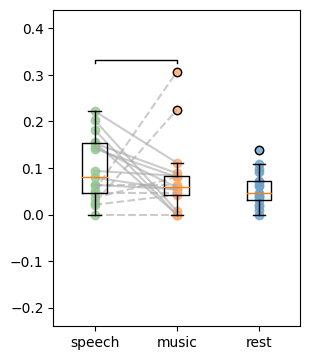

In [67]:

    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

count=0
#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_decrease_list['speech'],left_decrease_list['music'], left_decrease_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=left_decrease_list['speech'][i]
    pm=left_decrease_list['music'][i]
    pr=left_decrease_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(left_decrease_list['speech'],left_decrease_list['music'])[1]
pmr=stats.mannwhitneyu(left_decrease_list['music'],left_decrease_list['rest'])[1]
psr=stats.mannwhitneyu(left_decrease_list['rest'],left_decrease_list['speech'])[1]
print("numero trend expected ", str(count)+' su 17')
p=Gtest(left_decrease_list['speech'],left_decrease_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(left_decrease_list['speech'],left_decrease_list['music']))
print('p_value music - speech ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_decrease_list['speech'],left_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left_decrease_across_conditions.png', dpi=600)
plt.show()
plt.close()
    

numero trend expected  12 su 17
Gio test   0.025
MannwhitneyuResult(statistic=213.0, pvalue=0.01715825382063729)
p_value music - speech  0.01715825382063729
p_value music - rest  0.7989391331970226
p_value music - rest  0.014824314325254391


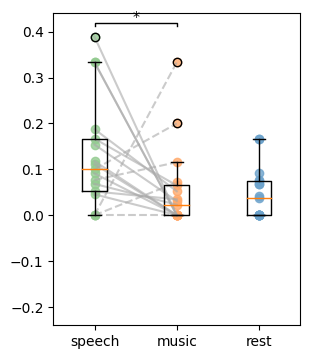

In [42]:

    
plt.figure(figsize=(2.4*1.25,2.8*1.25))

count=0
#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[right_decrease_list['speech'],right_decrease_list['music'], right_decrease_list['rest']]
for i in range(len(right_increase_list['speech'])):
    ps=right_decrease_list['speech'][i]
    pm=right_decrease_list['music'][i]
    pr=right_decrease_list['rest'][i]
    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if ps-pm>0:
        count+=1
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music', 'rest'])
pp=stats.mannwhitneyu(right_decrease_list['speech'],right_decrease_list['music'])[1]
pmr=stats.mannwhitneyu(right_decrease_list['speech'],right_decrease_list['rest'])[1]
psr=stats.mannwhitneyu(right_decrease_list['rest'],right_decrease_list['music'])[1]
print("numero trend expected ", str(count)+' su 17')
p=Gtest(right_decrease_list['speech'],right_decrease_list['music'])
print('Gio test  ', p)
print(stats.mannwhitneyu(right_decrease_list['speech'],right_decrease_list['music']))
print('p_value music - speech ', pp)
print('p_value music - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([right_decrease_list['speech'],right_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('right_decrease_across_conditions.png', dpi=600)
plt.show()
plt.close()
    

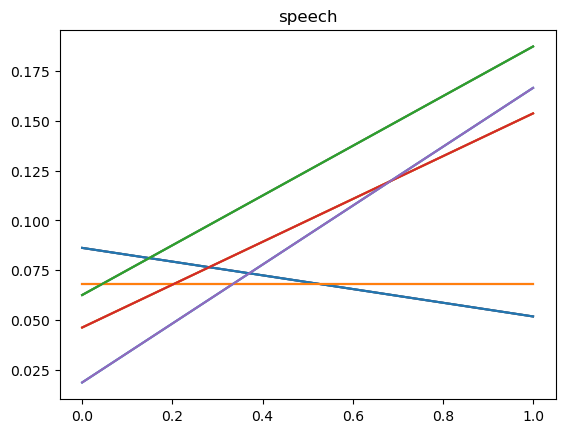

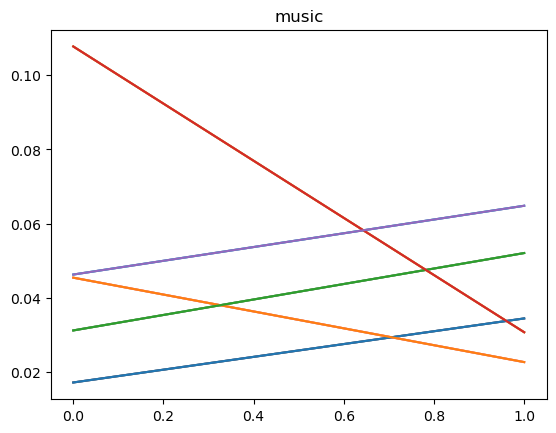

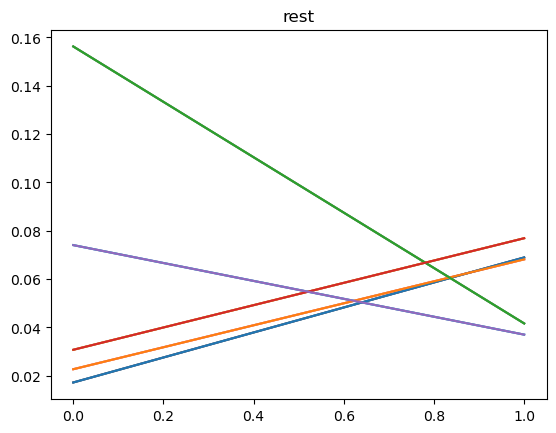

In [ ]:
left_decrease_list={}
right_decrease_list={}

for sound in sound_list:
    plt.title(sound)
    left_decrease_list[sound]=[]
    right_decrease_list[sound]=[]
    for subject in subject_list_corrected_right:
        left_decrease_list[sound].append(left_decrease[sound][subject])
        right_decrease_list[sound].append(right_decrease[sound][subject])
        

Gio test   0.1696
mannwhitney test
p_value speech - music  0.1528874090257627
p_value speech - rest  0.28552308959958794
p_value music - rest  0.43835179109696876


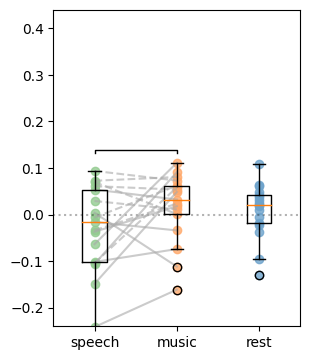

In [33]:
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))
# plt.title('left-right greater than expected')

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'],left_decrease_list['rest']-right_decrease_list['rest']]

for i in range(len(right_decrease_list['speech'])):
    
    ps=left_decrease_list['speech'][i]-right_decrease_list['speech'][i]
    pm=left_decrease_list['music'][i]-right_decrease_list['music'][i]
    pr=left_decrease_list['rest'][i]-right_decrease_list['rest'][i]

    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    plt.scatter(3,pr,color=C1['r'],alpha=.8)
    
    if pr-ps>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music','rest'])
pp=stats.kruskal(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'])[1]
pmr=stats.mstats.kruskalwallis(left_decrease_list['rest']-right_decrease_list['rest'],left_decrease_list['music']-right_decrease_list['music'])[1]
psr=stats.mstats.kruskalwallis(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['rest']-right_decrease_list['rest'])[1]

p=Gtest(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'])
print('Gio test  ', p)
print('mannwhitney test')
print('p_value speech - music ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.tight_layout(pad=0.35)
plt.savefig('left-right_decrease_with_rest.pdf', dpi=600)
plt.show()
plt.close()
    

Gio test   0.175
Wilcoxon test
p_value speech - music  0.120208740234375
p_value speech - rest  0.19144640357050802
p_value music - rest  0.644134521484375


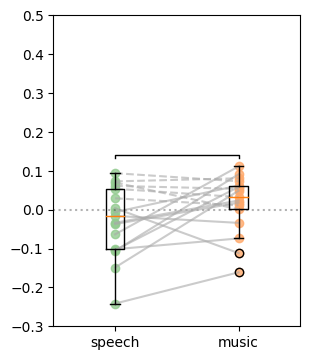

In [36]:
    
plt.figure(figsize=(2.4*1.25,2.8*1.25))
# plt.title('left-right greater than expected')

plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music']]

for i in range(len(right_decrease_list['speech'])):
    
    ps=left_decrease_list['speech'][i]-right_decrease_list['speech'][i]
    pm=left_decrease_list['music'][i]-right_decrease_list['music'][i]

    plt.scatter(1,ps,color=C1['s'],alpha=.8)
    plt.scatter(2,pm,color=C1['m'],alpha=.8)
    
    if pr-ps>0:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[ps,pm],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
pp=stats.wilcoxon(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'])[1]
pmr=stats.wilcoxon(left_decrease_list['rest']-right_decrease_list['rest'],left_decrease_list['music']-right_decrease_list['music'])[1]
psr=stats.wilcoxon(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['rest']-right_decrease_list['rest'])[1]

p=Gtest(left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music'])
print('Gio test  ', p)
print('Wilcoxon test')
print('p_value speech - music ', pp)
print('p_value speech - rest ', psr)
print('p_value music - rest ', pmr)

to_min=np.array([left_decrease_list['speech']-right_decrease_list['speech'],left_decrease_list['music']-right_decrease_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars_diff(p, bottom, top)
plt.ylim((-0.3,0.5))
plt.tight_layout(pad=0.35)
plt.savefig('left-right_decrease_with_rest.pdf', dpi=600)
plt.show()
plt.close()
    

['sub-14c725b6b803',
 'sub-28e70e7c7fbb',
 'sub-4247d6d6cdbf',
 'sub-44375d501493',
 'sub-83ebd5328120',
 'sub-95a634be7e05',
 'sub-9d783b836f5e',
 'sub-c1b7ce54ce05',
 'sub-c2a96116ddc4',
 'sub-cacae171ee15',
 'sub-e0bb6ccef2a5',
 'sub-ebf231d97f73']

MannwhitneyuResult(statistic=236.0, pvalue=0.0017222858797683106)


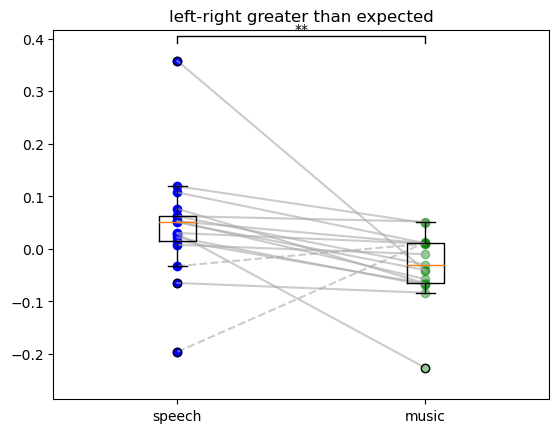

In [42]:

    
plt.title('left-right greater than expected')
box_plot_data=[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in range(len(right_increase_list['speech'])):
    pr=left_increase_list['speech'][i]-right_increase_list['speech'][i]
    ps=left_increase_list['music'][i]-right_increase_list['music'][i]
    plt.scatter(1,pr,color=C0[0],alpha=1.)
    plt.scatter(2,ps,color=C0[1],alpha=0.4)
    if pr-ps>0:
        plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6)
    else:
        plt.plot([1,2],[pr,ps],color='darkgray',alpha=0.6,linestyle='--')

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music'])
p=stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])[1]
print(stats.mannwhitneyu(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
to_min=np.array([left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']])
bottom, top = np.min(to_min), np.max(to_min)
bars(p, bottom, top)   
plt.ylim(-0.3,0.6)
plt.show()
plt.close()
    

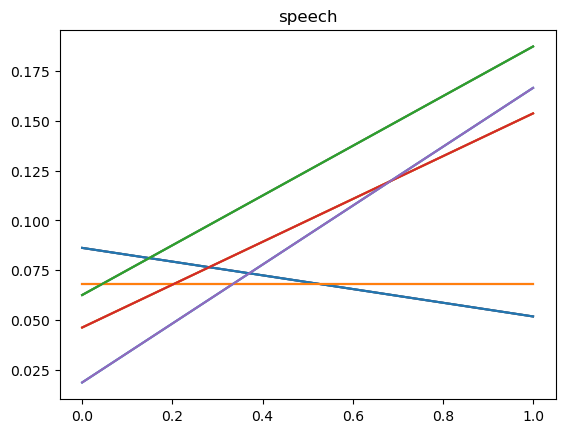

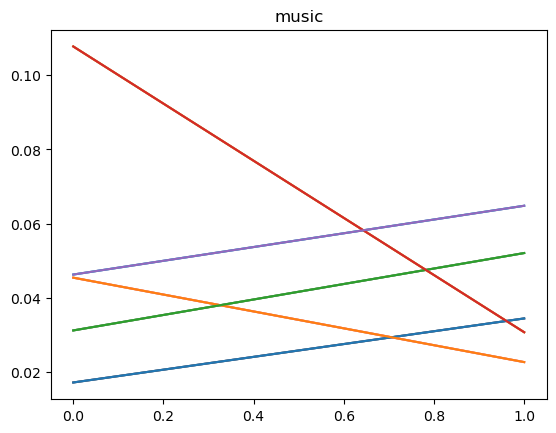

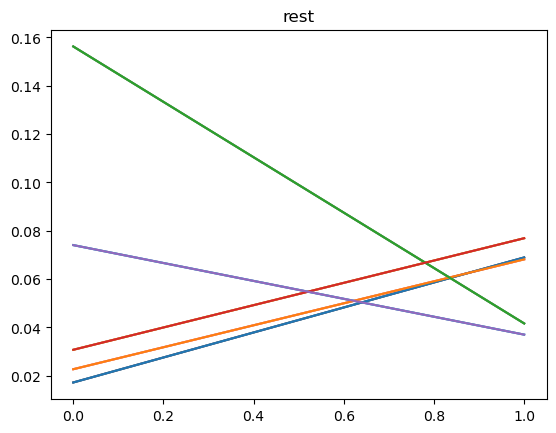

In [44]:
left_decrease_list={}
right_decrease_list={}

for sound in sound_list:
    plt.title(sound)
    left_decrease_list[sound]=[]
    right_decrease_list[sound]=[]
    for subject in subject_list_corrected_right:
        left_decrease_list[sound].append(left_decrease[sound][subject])
        right_decrease_list[sound].append(right_decrease[sound][subject])
        plt.plot([right_increase[sound][subject],right_decrease[sound][subject]])
    plt.show()
    plt.close()
    

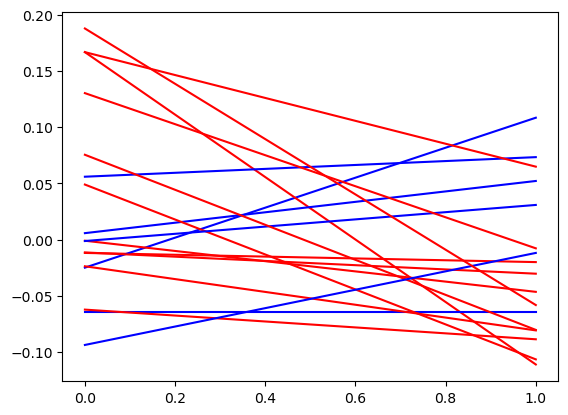

In [99]:
for subject in subject_list:
    if right_decrease['speech'][subject]-left_decrease['speech'][subject] > right_decrease['music'][subject]-left_decrease['music'][subject]:
        color='r'
    else:
        color='b'
    plt.plot([right_decrease['speech'][subject]-left_decrease['speech'][subject],right_decrease['music'][subject]-left_decrease['music'][subject]], color=color)
plt.show()
plt.close()
    

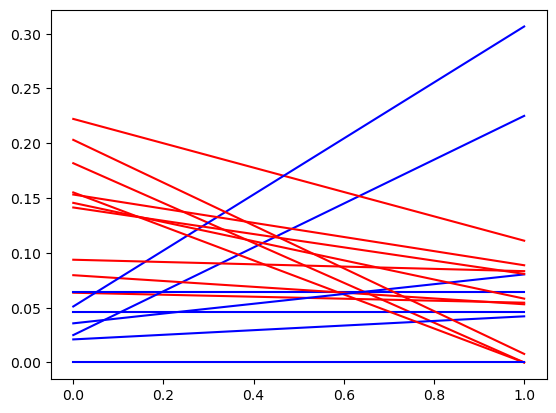

In [103]:
for subject in subject_list:
    if left_decrease['speech'][subject] > left_decrease['music'][subject]:
        color='r'
    else:
        color='b'
    plt.plot([left_decrease['speech'][subject],left_decrease['music'][subject]], color=color)
plt.show()
plt.close()
    

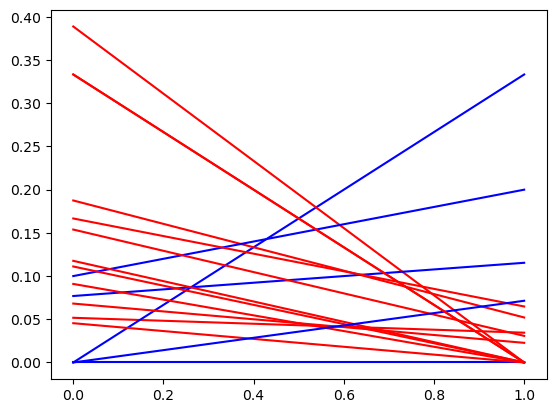

In [104]:
for subject in subject_list:
    if right_decrease['speech'][subject]> right_decrease['music'][subject]:
        color='r'
    else:
        color='b'
    plt.plot([right_decrease['speech'][subject],right_decrease['music'][subject]], color=color)
plt.show()
plt.close()
    

In [122]:
scipy.stats.ttest_ind(np.array(right_decrease_list['music']),np.array(left_decrease_list['music']))

Ttest_indResult(statistic=-3.0004608343719297, pvalue=0.0037327220766711355)

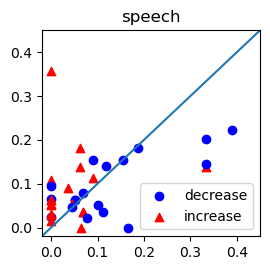

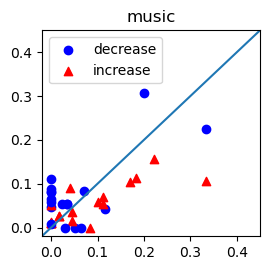

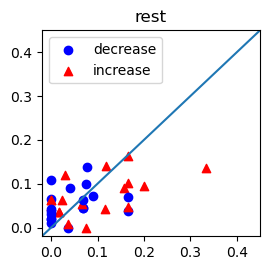

In [80]:
for sound in sound_list:
    plt.figure(figsize=(2.8,2.8))
    plt.title(sound)
    for isub, subject in enumerate(subject_list):
        
        if isub==0:
            
            plt.scatter(right_decrease[sound][subject], left_decrease[sound][subject], color="b", label="decrease")
            plt.scatter(right_increase[sound][subject], left_increase[sound][subject], marker="^", color="r", label="increase")
        
        plt.scatter(right_increase[sound][subject], left_increase[sound][subject], marker="^", color="r")
        plt.scatter(right_decrease[sound][subject], left_decrease[sound][subject], color="b")

    plt.plot([-0.02,.45],[-0.02,.45])
    plt.xlim(-0.02,0.45)
    plt.ylim(-0.02,0.45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path+"figure/scatter_plot_"+sound+".pdf", dpi=600)
    plt.show()

In [106]:
enga={}

for sound in sound_list:
    enga[sound]={}
    
for subject in subject_list[:-7]:
    pvalue=1
    enga['music'][subject]=np.where(sig_dict[subject]['p_m']==pvalue,1,0)
    enga['rest'][subject]=np.where(sig_dict[subject]['p_r']==pvalue,1,0)
    enga['speech'][subject]=np.where(sig_dict[subject]['p_s']==pvalue,1,0)
    
    

In [107]:

left_right_decrease={}

for o, sound in enumerate(['speech','music', 'rest']):
    left_right_decrease[sound]={}

        
        
    print(sound) 
    with h5py.File(pjoin(path+ 'raw_data/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

        im = f[orientation]['imp'][...]

    for isub,subject in enumerate(subject_list[:-7]):

        with h5py.File(pjoin(path+ 'raw_data/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']


        with h5py.File(pjoin(path + 'raw_data/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

        ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

        chnames=chnames[ch_i]

        # collect coordinates for this specific orientation (only one patient)
        with h5py.File(pjoin(path+ 'raw_data/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

            coordinates=f['mayavi'][orientation]['xy'][...]

        coordinates=coordinates[ch_i]

        # make sure you only select the left electrodes for the left orientation and
        # right electrodes for the right orientation
        if subject in ('sub-83ebd5328120', 'sub-aea837fa1826', 'sub-a4e7fc9daa96'):
            chnames = np.array([x.replace('Ip', "IP") for x in chnames])
            chnames = np.array([x.replace('p', "'") for x in chnames])
            chnames = np.array([x.replace('PIP', "PI'") for x in chnames])     


        _, _, left_i, right_i = mp.split_hemis(chnames)


        per_l=np.sum(enga[sound][subject][left_i])/len(enga[sound][subject][left_i])

        per_r=np.sum(enga[sound][subject][right_i])/len(enga[sound][subject][right_i])
        
        
        if per_l==0:
            per_l=0.001
            
        left_right_decrease[sound][subject]=per_r/per_l
        print(subject, per_r/per_l)

speech
sub-14c725b6b803 0.8128078817733991
sub-26176ef8a8d0 0.0
sub-28e70e7c7fbb 1.7500000000000002
sub-4247d6d6cdbf 0.0
sub-44375d501493 0.856060606060606
sub-45a6830d263e 1.03125
sub-82e330f8aadd 1.9571428571428573
sub-83ebd5328120 3.653846153846154
sub-95a634be7e05 0.9772727272727273
sub-9d783b836f5e 0.9914529914529915
music
sub-14c725b6b803 0.632183908045977
sub-26176ef8a8d0 1.4814814814814814
sub-28e70e7c7fbb 0.0
sub-4247d6d6cdbf 0.0
sub-44375d501493 0.42803030303030304
sub-45a6830d263e 52.083333333333336
sub-82e330f8aadd 0.6523809523809524
sub-83ebd5328120 2.7403846153846154
sub-95a634be7e05 0.0
sub-9d783b836f5e 30.76923076923077
rest
sub-14c725b6b803 1.5172413793103448
sub-26176ef8a8d0 4.444444444444445
sub-28e70e7c7fbb 0.0
sub-4247d6d6cdbf 0.0
sub-44375d501493 1.1006493506493507
sub-45a6830d263e 0.4583333333333333
sub-82e330f8aadd 0.0
sub-83ebd5328120 0.0
sub-95a634be7e05 0.0
sub-9d783b836f5e 0.5576923076923077


KeyError: 'gain'

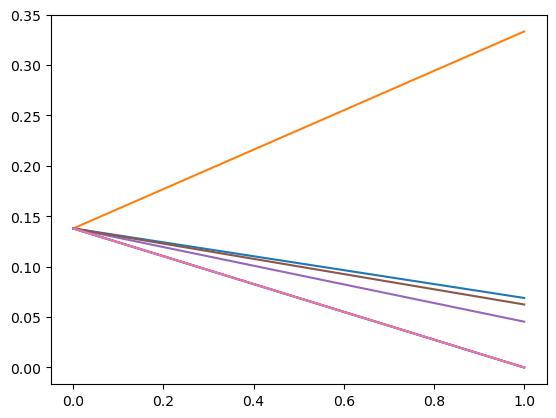

In [101]:
for subject in subject_list[:-7]:
    
    plt.plot(left_right['speech'][subject]['gain'])
plt.show()
plt.close()

In [42]:
left_right['speech'][subject_list[0]].keys()

dict_keys(['loss'])

In [42]:
 
    
    with h5py.File(pjoin(path + 'raw_data/mayavi_electrodes.hdf5'), 'r') as f:
        print(f)

<HDF5 file "mayavi_electrodes.hdf5" (mode r)>


In [11]:
datatipe='hgenv_down100'
eng_simple={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    eng_simple[subject]={}
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
    for sound in sound_list:
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'][index_all[sound],:]
        eng_simple[subject][sound]=scipy.stats.zscore(np.sum(aval, axis=0))





    

    

2.78534246404477
2.7985919037396925
2.8138171563785437
2.7742837529435107
2.803148765547773
2.818625307029934
2.9744978125454247
2.7507264122036497
2.774284818922206
2.750861898649132
2.8552720483703933
2.7331326834817284
2.897258743666651
2.7761437719778965
2.8089245753814596
2.734310175019014
2.79738475441734
2.7654285000333187


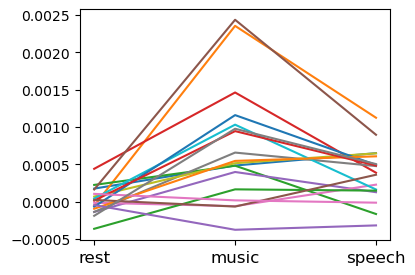

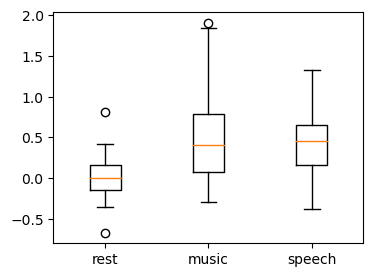

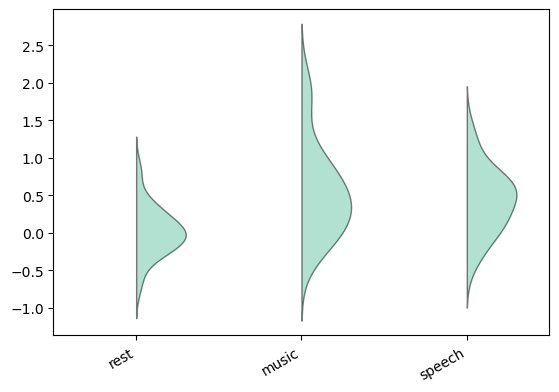

In [12]:
fs=12
engag={}        
for subject in subject_list:
    engag[subject]=[]
    for sound in sound_list:
        engag[subject].append(np.mean(eng_simple[subject][sound][ch_H_i[subject]]))
        

plt.figure(figsize=(4,3))
for subject in subject_list:
    plt.plot([np.mean(eng_simple[subject]['rest'][ch_H_i[subject]])/mem['rest'],np.mean(eng_simple[subject]['music'][ch_H_i[subject]])/mem['music'],np.mean(eng_simple[subject]['speech'][ch_H_i[subject]])/mem['speech']])
plt.xticks([0,1,2], sound_list, fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_subjects_lines.png', dpi=600)
plt.show()
plt.close()

engag_boxplot=np.zeros((3,19))

for i, sound in enumerate(sound_list):
    for j, subject in enumerate(subject_list):
        engag_boxplot[i,j]=engag[subject][i]

plt.figure(figsize=(4,3))
plt.boxplot(list(engag_boxplot), labels=sound_list)
#plt.legend(fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_boxplot.png', dpi=600)
plt.show()
plt.close()  

import seaborn as sns 
import pandas as pd

df = pd.DataFrame(engag_boxplot, columns=['normalized_engagement']*19, index=sound_list)
#sns.kdeplot(data=df, y='normalized_engagement', fill=True,  alpha=.5, linewidth=0)
from statsmodels.graphics.boxplots import violinplot

fig, ax = plt.subplots()
violinplot(data=df.values, ax=ax, labels=sound_list, side='right', show_boxplot=False)
fig.autofmt_xdate()



In the following part I performed a statistical test to confirm the fact that during speech and music listening the study of the engagement of H allows to perfectly distinguish between different conditions

In [115]:
#between speech and rest

real_diff=np.mean(engag_boxplot[1])-np.mean(engag_boxplot[0])
count=0
test_boxplot=np.concatenate((engag_boxplot[0], engag_boxplot[1]))

for i in range(100000):
    aa=np.array(random.sample(list(test_boxplot),19))
    bb=np.array([i for i in test_boxplot if i not in aa])
    diff=np.mean(aa)-np.mean(bb)
    if diff>real_diff:
        count +=1

    

In [116]:
count/100000

0.00059

## trough studies, not correlated instant of time 

Here we study those moment when correlation is not highe 

In [241]:

datatipe='hgenv_down100'
engagement={}
enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)



2.818625307029934
2.7331326834817284
2.7507264122036497
2.9744978125454247
2.750861898649132
2.803148765547773
2.734310175019014
2.897258743666651
2.78534246404477
3.334984151824247
2.8089245753814596
2.7761437719778965
2.8552720483703933
2.7654285000333187
2.79738475441734
2.774284818922206
2.7742837529435107
2.8138171563785437
2.7985919037396925


In [140]:

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
    
    
    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
    
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    engagementr[sound]={}
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
        
        meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_troughs')
sv.saving(meta_engagement, path+'meta_engagement_troughs' )


2.7761437719778965
2.9744978125454247


KeyboardInterrupt: 

In [242]:
enga_null[subject_list[0]].shape



(566, 150)

In [243]:

engagement={}

for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    
    for subject in subject_list:
        print(subject)
        zdata=data[subject]  #loading the data of the three conditions that we saved before 
        
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            #print(f.keys())
            #print('chnames', f['chnames'].shape)
            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
            #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)     
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
                                                               
        engagementt=np.sum(aval, axis=0)/mem[sound]
        
        sum_enga_null=np.sum(enga_null[subject], axis=1)
        
        print(np.sum(engagementt))
        
        aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

        bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.2)[0])
        
        print(len(aa.intersection(bb)))
        
        mean_null=np.mean(enga_null[subject][list(aa.intersection(bb)),:], axis=0)
        
        enn=[]
        for i in range(len(engagementt)):
            aaa=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]>engagementt[i])[0])
            bbb=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]<engagementt[i])[0])
            enn.append(aaa/(bbb+1))
            #plt.title(clean_chnames[i])
            #plt.hist(enga_null[subject][list(aa.intersection(bb)),:][i])
            #plt.axvline(engagementt[i])
            #plt.show()
            #plt.close()
            
        engagement[sound][subject]=np.array(enn)
        
        #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)
        
        #engagement[sound][subject]=(engagementt-mean_null)/std_null
        
        #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        #print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_peaks_same_sum')
#sv.saving(meta_engagement, path+'meta_engagement_peaks' )

sub-3ef8645f99c5
2.818625307029934
(28918, 150)
2.3228066146072575
66
sub-95a634be7e05
2.7331326834817284
(28918, 151)
2.392397795130914
109
sub-14c725b6b803
2.7507264122036497
(28918, 168)
2.638033991731741
115
sub-aea837fa1826
2.9744978125454247
(28918, 167)
2.5312356453835556
61
sub-ebf231d97f73
2.750861898649132
(28918, 146)
2.303858520900322
101
sub-28e70e7c7fbb
2.803148765547773
(28918, 117)
1.8155718879191547
121
sub-cacae171ee15
2.734310175019014
(28918, 116)
1.7624023886081766
131
sub-44375d501493
2.897258743666651
(28918, 157)
2.451998162609095
114
sub-e0bb6ccef2a5
2.78534246404477
(28918, 110)
1.6995865870463942
157
sub-82e330f8aadd
3.334984151824247
(28918, 147)
2.3720716582452916
6
sub-83ebd5328120
2.8089245753814596
(28918, 121)
1.8870004593477263
105
sub-4247d6d6cdbf
2.7761437719778965
(28918, 108)
1.726228755167662
109
sub-fccb4adbfadc
2.8552720483703933
(28918, 109)
1.698897565457051
111
sub-9d783b836f5e
2.7654285000333187
(28918, 123)
2.0527101515847495
93
sub-26176ef

In [2]:
abb=[]
app=[]

for k in [0.1]:
    count2=0
    count=0

    for i in range(18):
        print(len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0]))
        count+=len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0])
        count2+=len(np.where(np.array(engagement['speech'][subject_list[i]])<k)[0])
    abb.append(count)
    app.append(count2)

print(count)
plt.plot(abb)
plt.plot(app)

NameError: name 'np' is not defined

Analisi, facciamo variare le soglie di correlazione massima e minima e vediamo che succede alle regioni significative. Vogliamo far vedere che nei momenti in cui i soggetti sono molto correlati ci sono cose in h e regioni di interesse

In [50]:
datatipe='hgenv_down100'
engagement={}
enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)


engagement={}

window_length=50
time_interval=1

dcorr_all=sv.loading(path+'dcorr_all_'+str(window_length)+'_'+str(time_interval))

for per in np.arange(0,100, 9)[1:]:

    ind_all={}
    engagement[per]={}
    
    for sound in sound_list:
    
        corr_thres_l=np.percentile(dcorr_all[sound], per)
        corr_thres_h=np.percentile(dcorr_all[sound], per+1)
        print(corr_thres_l, corr_thres_h)
        aa=set(np.where(dcorr_all[sound]>corr_thres_l)[0])
        bb=set(np.where(dcorr_all[sound]<=corr_thres_h)[0])
        print(len(aa), len(bb))
        ind_all[sound]=list(aa)
        print(len(aa.intersection(bb)))
    
    index_all=dict()
    for sound in sound_list:
    
        aall=set()
        for i in ind_all[sound]:
            aall.update(np.arange(i,i+window_length))
            
        index_all[sound]=list(aall)

    mem={}
    m=min(len(index_all['speech']), len(index_all['music']))
    print(len(index_all['speech']), len(index_all['music']), len(index_all['rest']))
    for sound in ['speech', 'music', 'rest']:
        #index_all[sound]=index_all[sound][:m]
        mem[sound]=len(index_all[sound])
    
    for sound in ['music', 'speech']:
    
        engagement[per][sound]={}    

        for subject in subject_list:
            print(subject)
            zdata=data[subject]  #loading the data of the three conditions that we saved before 

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                #print(f.keys())
                #print('chnames', f['chnames'].shape)
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            #Here we load the list of bad channels
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
                #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
                #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

            ## Cleaning from artifacts
            #List of bad channels indices
            ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

            clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
                #the threshold is derived as the 99th percentile of the data
            thres=np.percentile(zdata['rest'], 99)
            print(thres)     

            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)

            print(avalanches['Zbin'].shape)
            aval=avalanches['Zbin'][index_all[sound],:]

            engagementt=np.sum(aval, axis=0)/mem[sound]

            sum_enga_null=np.sum(enga_null[subject], axis=1)

            print(np.sum(engagementt))

            aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

            bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.1)[0])

            print(len(aa.intersection(bb)))

            mean_null=np.mean(enga_null[subject], axis=0)

            enn=[]
            for i in range(len(engagementt)):
                aaa=len(np.where(enga_null[subject][:,i]>engagementt[i])[0])
                bbb=len(np.where(enga_null[subject][:,i]<engagementt[i])[0])
                enn.append(aaa/(bbb+1))
                #plt.title(clean_chnames[i])
                #plt.hist(enga_null[subject][list(aa.intersection(bb)),:][i])
                #plt.axvline(engagementt[i])
                #plt.show()
                #plt.close()

            engagement[per][sound][subject]=np.array(enn)

            #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)

            #engagement[sound][subject]=(engagementt-mean_null)/std_null

            #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]

            #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))

            #print(engagement[sound][subject])

sv.saving(engagement, path+'engagement_percentile1__99_asound_asubject')

2.7507264122036497
2.7742837529435107
2.734310175019014
2.818625307029934
2.8089245753814596
2.7761437719778965
2.803148765547773
2.774284818922206
2.7654285000333187
2.79738475441734
2.9744978125454247
2.8138171563785437
2.78534246404477
2.7985919037396925
3.334984151824247
2.897258743666651
2.750861898649132
2.8552720483703933
2.7331326834817284
-0.016053813196017917 -0.015461240314665111
25739 2829
283
-0.013092963009911024 -0.012525597649224382
26269 2887
288
-0.01323864600553319 -0.012521295700879398
26103 2869
287
28685 28874 28294
sub-14c725b6b803
2.7507264122036497
(28918, 168)
2.6320911546720236
3684
sub-a4e7fc9daa96
2.7742837529435107
(28918, 115)
1.801863267991965
2437
sub-cacae171ee15
2.734310175019014
(28918, 116)
1.7712821223245825
4946
sub-3ef8645f99c5
2.818625307029934
(28918, 150)
2.2236267922698616
2270
sub-83ebd5328120
2.8089245753814596
(28918, 121)
1.886922490822193
3718
sub-4247d6d6cdbf
2.7761437719778965
(28918, 108)
1.6951582738796147
4524
sub-28e70e7c7fbb
2.803

(28735, 117)
1.769454623841345
4771
sub-c1b7ce54ce05
2.774284818922206
(28735, 135)
2.0253287346410866
2744
sub-9d783b836f5e
2.7654285000333187
(28735, 123)
1.9753179564561327
3688
sub-26176ef8a8d0
2.79738475441734
(28735, 86)
1.340482862685924
4057
sub-aea837fa1826
2.9744978125454247
(28735, 167)
2.3585542861248827
2132
sub-45a6830d263e
2.8138171563785437
(28735, 107)
1.5666091830135802
3670
sub-e0bb6ccef2a5
2.78534246404477
(28735, 110)
1.706258532729755
5371
sub-c2a96116ddc4
2.7985919037396925
(28735, 139)
2.1875763454767547
3517
sub-82e330f8aadd
3.334984151824247
(28735, 147)
2.3454049004814257
366
sub-44375d501493
2.897258743666651
(28735, 157)
2.4431630380110656
4100
sub-ebf231d97f73
2.750861898649132
(28735, 146)
2.1768700150894587
3733
sub-fccb4adbfadc
2.8552720483703933
(28735, 109)
1.671768340878063
3795
sub-95a634be7e05
2.7331326834817284
(28735, 151)
2.417403175971833
3457
-0.0055726531611229885 -0.005266205737888638
18102 10466
283
-0.00166818508949638 -0.00132483840183299

KeyboardInterrupt: 

preplotting 

In [49]:
engagement[99]['music']

{'sub-14c725b6b803': array([0.68149646, 0.30023456, 0.73953975, 0.81947484, 0.82146769,
        0.31670625, 0.60366442, 0.61770428, 0.95877503, 1.1824147 ,
        0.96572104, 0.68149646, 0.29315708, 0.86853933, 0.76165254,
        1.06840796, 0.42015371, 0.53413284, 0.76914894, 0.80173348,
        0.74684874, 0.60521236, 0.77481323, 0.32721468, 0.77481323,
        0.59596929, 0.55565949, 0.24104478, 0.6208577 , 0.43362069,
        0.87485908, 0.89840183, 0.33574297, 1.17670157, 0.82346491,
        0.77481323, 0.54553903, 0.77292111, 0.72510373, 0.73048907,
        0.76165254, 0.76914894, 0.27043545, 0.24943651, 0.96804734,
        1.22326203, 0.84777778, 0.69693878, 0.87274775, 0.69175992,
        0.8664422 , 0.28615623, 0.82948295, 1.08135169, 0.35644372,
        0.91810842, 0.67472306, 0.63520157, 0.44232437, 0.91810842,
        0.45749343, 0.43115318, 0.31462451, 0.62561095, 0.34221146,
        0.3509342 , 0.30944882, 0.78817204, 1.02311436, 0.82346491,
        1.09974747, 0.353132

In [43]:
enga={}
for sound in ['speech','music', 'rest']:
    enga[sound]={}
    for subject in subject_list:
        pvalue=0.05
        if pvalue > min(engagement[per][sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(sig[per][sound][subject]<pvalue,1,0)


9

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
18

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
27

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
36

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
45

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes
54

yes

yes

yes

yes

yes

yes

yes

yes

yes
63

yes

yes

yes

yes

yes

yes

yes

yes
72

yes

yes

yes

yes

yes

yes

yes

yes
81

yes

yes

yes

yes

yes

yes

yes

yes
90

yes

yes

yes

yes

yes

yes

yes

yes

yes
99

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes

yes


plotting

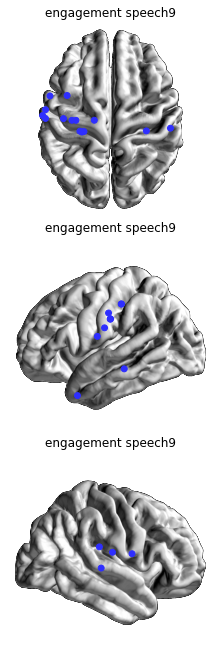

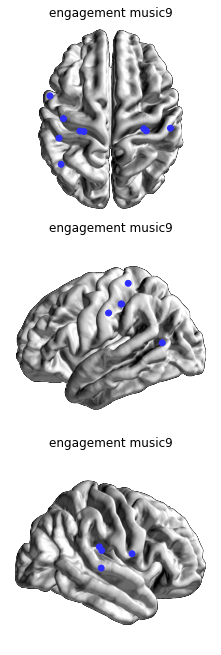

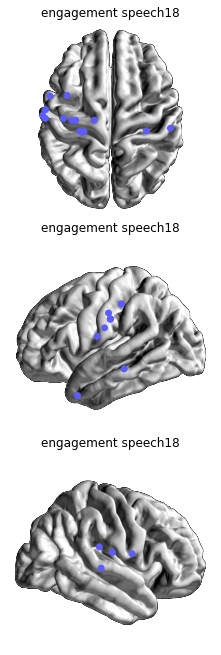

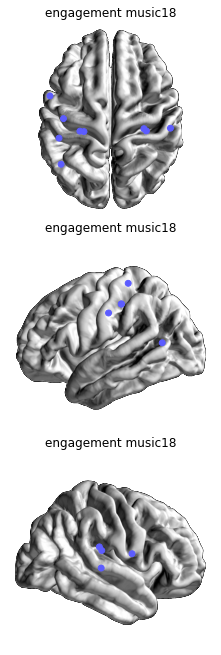

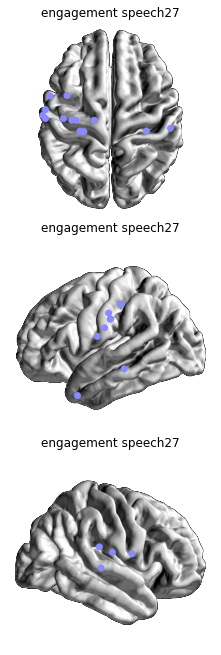

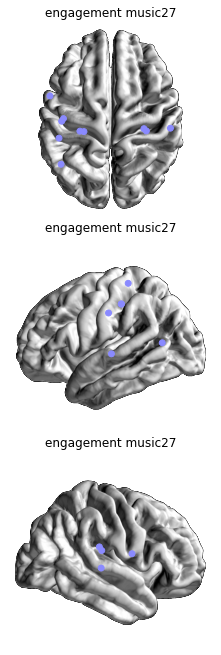

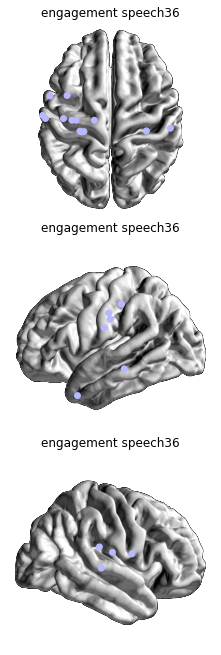

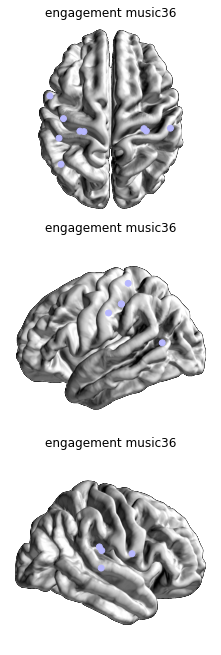

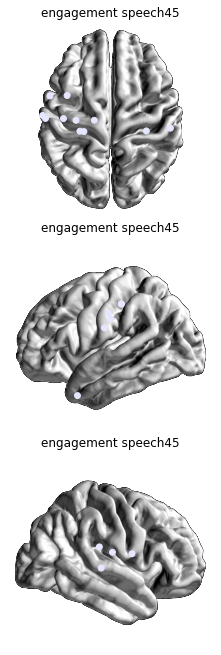

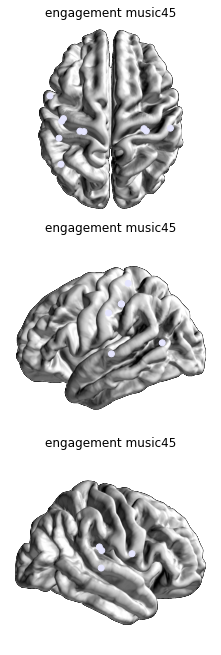

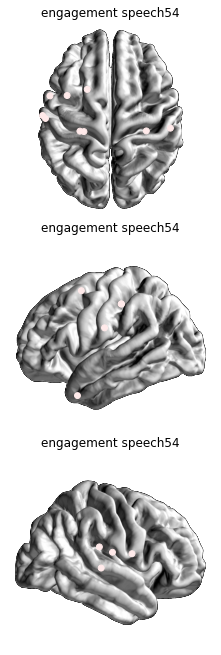

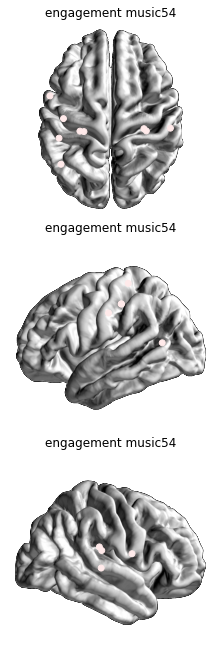

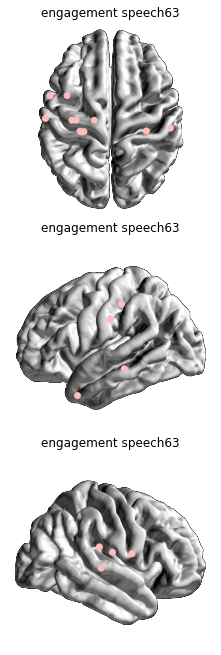

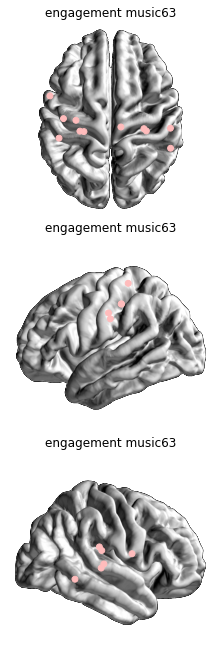

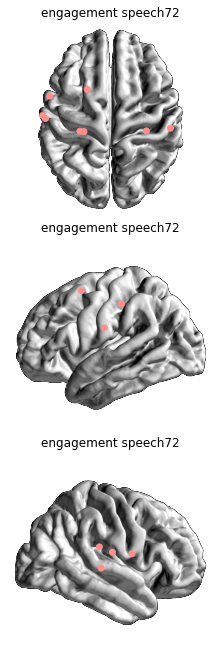

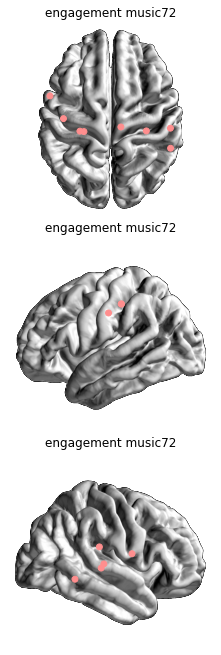

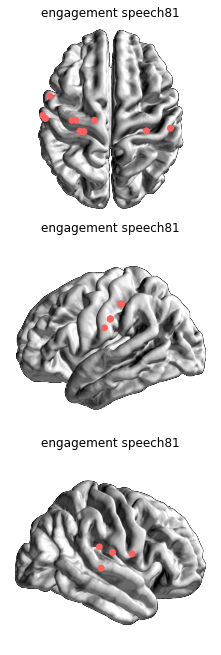

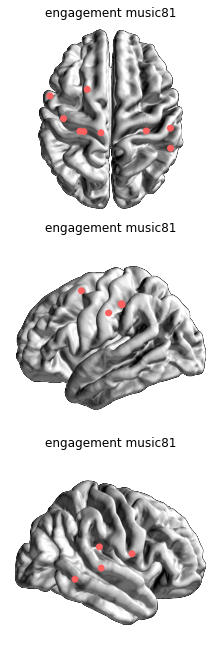

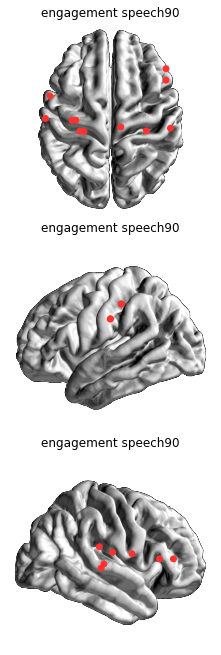

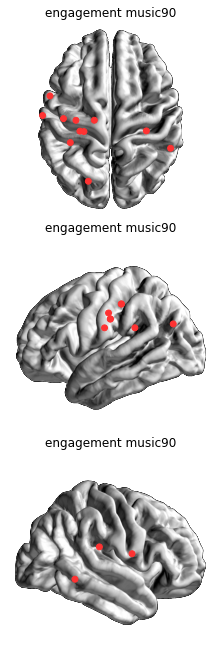

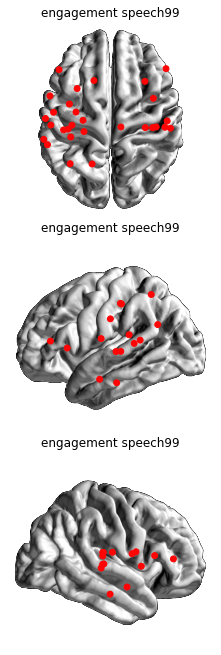

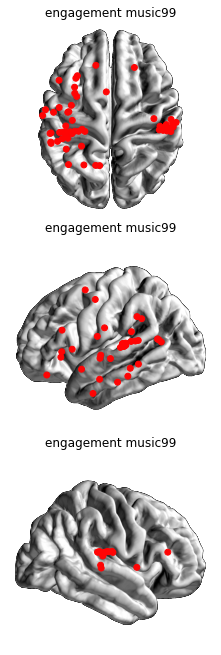

In [44]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''

for per in np.arange(0,100,9)[1:]:
    
    for o, sound in enumerate(['speech','music']):
        
        fig, ax= plt.subplots(3,1, figsize=(3,9))
        
        for j, orientation in enumerate(['top','left','right']):


            axes=ax[j]
            axes.spines['top'].set_visible(False)
            axes.spines['right'].set_visible(False)
            axes.spines['bottom'].set_visible(False)
            axes.spines['left'].set_visible(False)

            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:

                im = f[orientation]['imp'][...]

            for isub,subject in enumerate(subject_list[:-1]):            

                with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                    #print(f.keys())
                    #print('chnames', f['chnames'].shape)

                    chnames = f['chnames'][...].astype('U')
                    x=f['chlocs']


                with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                    #print(f.keys())
                    #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                    bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')

                ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]

                chnames=chnames[ch_i]

                # collect coordinates for this specific orientation (only one patient)
                with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

                    coordinates=f['mayavi'][orientation]['xy'][...]

                coordinates=coordinates[ch_i]

                # make sure you only select the left electrodes for the left orientation and
                # right electrodes for the right orientation


                if orientation in ('left', 'right'):

                    _, _, left_i, right_i = mp.split_hemis(chnames)
                    x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]

                    if orientation == 'left':
                        cmap=[]
                        for i in range(len(engagement[per][sound][subject][left_i])):
                            cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject][left_i]))[i,:]))

                    if orientation == 'right':
                        cmap=[]
                        for i in range(len(engagement[per][sound][subject][right_i])):
                            cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject][right_i]))[i,:]))



                elif orientation == 'top':
                    cmap=[]
                    for i in range(len(engagement[per][sound][subject])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[per][sound][subject]))[i,:]))
                    x_h = coordinates


                axes.imshow(im)
                if orientation =='left':
                    if left_i != []:
                        axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject][left_i]))

                if orientation =='right':

                    if right_i != []:
                        axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject][right_i]))

                if orientation =='top':
                    axes.scatter(*x_h.T, color=cm.bwr(per/100), s=35*np.ones(len(x_h)), marker='o', alpha=(enga[per][sound][subject]))


                axes.title.set_text('engagement '+sound+str(per))
                axes.set_xticks([])
                axes.set_yticks([])

        plt.tight_layout(pad=0.35)
        plt.savefig(path+'figure/brain_plots_all_channels_thres6std_9495'+sound+str(per)+'.png', dpi=600)


Analisi proposta da Fufo, contare quante volte durante tutto il tempo le mie regioni si allontanano da quello che spiegherebbe il rest. Io qua lo faccio comparando finestre di taglia simile.

In [46]:
datatipe='hgenv_down100'

enga_null={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)

    engagement_nu=[]
    
    for i in np.arange(0, len(avalanches['Zbin'])-50,1):
        aval=avalanches['Zbin'][i:i+50, :]
        engagement_nu.append(np.sum(aval, axis=0)/50)
        
    enga_null[subject]=np.array(engagement_nu)


temporal_engagement={}

for sound in ['music', 'speech']:
    
    temporal_engagement[sound]={}    

    for subject in subject_list:
        print(subject)
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:

            #print(f.keys())               #print('chnames', f['chnames'].shape)
            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)     

        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)

        print(avalanches['Zbin'].shape)
        
        enga_list=[]
        for winb in range(len(avalanches['Zbin'])-50):
            
            aval=avalanches['Zbin'][winb:winb+50,:]

            engagementt=np.sum(aval, axis=0)/50

            sum_enga_null=np.sum(enga_null[subject], axis=1)

            #print(np.sum(engagementt))

            aa=set(np.where(sum_enga_null>np.sum(engagementt)-0.1)[0])

            bb=set(np.where(sum_enga_null<np.sum(engagementt)+0.15)[0])

            #print(len(aa.intersection(bb)))

            mean_null=np.mean(enga_null[subject][list(aa.intersection(bb)),:], axis=0)

            enn=[]
            for i in range(len(engagementt)):
                aaa=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]>engagementt[i])[0])
                bbb=len(np.where(enga_null[subject][list(aa.intersection(bb)),i]<engagementt[i])[0])
                enn.append(aaa/(bbb+1))
                
            enga_list.append(enn)
            
        temporal_engagement[sound][subject]=np.array(enga_list)

            #std_null=np.std(enga_null[subject][list(aa.intersection(bb)), :], axis=0)

            #engagement[sound][subject]=(engagementt-mean_null)/std_null

            #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]

            #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))

            #print(engagement[sound][subject])

#sv.saving(engagement, path+'engagement_percentile1__99_asound_asubject')

2.7507264122036497
2.7742837529435107
2.734310175019014
2.818625307029934
2.8089245753814596
2.7761437719778965
2.803148765547773
2.774284818922206
2.7654285000333187
2.79738475441734
2.9744978125454247
2.8138171563785437
2.78534246404477
2.7985919037396925
3.334984151824247
2.897258743666651
2.750861898649132
2.8552720483703933
2.7331326834817284
sub-14c725b6b803
2.7507264122036497
(28918, 168)


KeyboardInterrupt: 

In [33]:
engagement[9]['speech']

{'sub-14c725b6b803': array([0.75996016, 0.80122324, 0.81977343, 0.88983957, 0.91960891,
        0.64678472, 1.07151231, 0.68929254, 0.81603289, 0.74691053,
        0.70313253, 0.67092199, 0.79847328, 0.88178914, 0.76965448,
        0.82919255, 0.67092199, 0.57697456, 0.79390863, 0.80122324,
        0.78214826, 0.63990719, 1.00681431, 0.9248366 , 0.77320622,
        0.69903846, 0.64448581, 0.67965779, 0.68125595, 0.83489097,
        0.80952381, 0.26712083, 0.69010043, 0.97430168, 0.75996016,
        0.74260355, 0.56371681, 0.96442468, 0.78846154, 0.56164384,
        0.74260355, 0.91752577, 0.2461213 , 0.31816486, 0.85123101,
        0.87579618, 0.73065622, 0.58831461, 0.77498744, 0.86589229,
        0.70889749, 0.88379531, 0.27904452, 0.94282573, 0.88279169,
        0.70559846, 0.75558867, 0.26440072, 0.79027356, 0.75996016,
        0.73405299, 0.26575931, 0.35366479, 0.38969721, 0.3957346 ,
        0.31816486, 0.31326644, 0.73150416, 0.73150416, 0.75037147,
        0.95033113, 0.933260

In [38]:
cm.bwr(0.2)

(0.4, 0.4, 1.0, 1.0)

In [14]:
np.arange(0,37,9)

array([ 0,  9, 18, 27, 36])

In [15]:
engagement[2]['speech']

KeyError: 2

Here we compute the engagement

In [169]:
engagement_null_std=sv.loading(path + 'engagement_null_std_9495')
engagement_null_mean=sv.loading(path + 'engagement_null_mean_9495')


engagement={}
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        print(sound, len(index_all[sound]))
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)
        engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
        
        #meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        #engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        #print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_peaks_9495')
#sv.saving(meta_engagement, path+'meta_engagement_peaks' )



2.818625307029934
(28918, 150)
music 783
0
2.7331326834817284
(28918, 151)
music 783
0
2.7507264122036497
(28918, 168)
music 783
0
2.9744978125454247
(28918, 167)
music 783
0
2.750861898649132
(28918, 146)
music 783
0
2.803148765547773
(28918, 117)
music 783
0
2.734310175019014
(28918, 116)
music 783
0
2.897258743666651
(28918, 157)
music 783
0
2.78534246404477
(28918, 110)
music 783
0
3.334984151824247
(28918, 147)
music 783
0
2.8089245753814596
(28918, 121)
music 783
0
2.7761437719778965
(28918, 108)
music 783
0
2.8552720483703933
(28918, 109)
music 783
0
2.7654285000333187
(28918, 123)
music 783
0
2.79738475441734
(28918, 86)
music 783
0
2.774284818922206
(28918, 135)
music 783
0
2.7742837529435107
(28918, 115)
music 783
0
2.8138171563785437
(28918, 107)
music 783
0
2.7985919037396925
(28918, 139)
music 783
0
2.818625307029934
(28735, 150)
speech 1184
0
2.7331326834817284
(28735, 151)
speech 1184
0
2.7507264122036497
(28735, 168)
speech 1184
0
2.9744978125454247
(28735, 167)
speech 

In [10]:
datatipe='hgenv_down100'
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

eng_simple={}

for sound in sound_list:
    
    eng_simple[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        #print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        #print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        #print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)/mem[sound]
        eng_simple[sound][subject]=stats.zscore(engagementt)
        
        #print(engagement[sound][subject])
        
sv.saving(eng_simple, path+'engagement_peaks_simple')


In [11]:
mem

{'speech': 1184, 'music': 783, 'rest': 1847}

{'rest': {'sub-3ef8645f99c5': array([0.01840823, 0.01245263, 0.01786681, 0.01136979, 0.01136979,
         0.02436383, 0.01407688, 0.01353546, 0.01732539, 0.01028695,
         0.02273958, 0.02003249, 0.01407688, 0.01353546, 0.02003249,
         0.00974553, 0.01515972, 0.01353546, 0.01570114, 0.01515972,
         0.01732539, 0.01245263, 0.01515972, 0.01732539, 0.01245263,
         0.01894965, 0.01624256, 0.0205739 , 0.01299404, 0.01353546,
         0.01732539, 0.01082837, 0.01299404, 0.01028695, 0.01299404,
         0.01245263, 0.01299404, 0.01732539, 0.02003249, 0.01299404,
         0.01082837, 0.01191121, 0.01678397, 0.01028695, 0.01407688,
         0.01570114, 0.01570114, 0.02165674, 0.01949107, 0.02652951,
         0.0086627 , 0.01678397, 0.02003249, 0.00920411, 0.0146183 ,
         0.00487277, 0.02652951, 0.01570114, 0.01732539, 0.01678397,
         0.01949107, 0.01515972, 0.01515972, 0.01840823, 0.0146183 ,
         0.01082837, 0.01570114, 0.00974553, 0.01353546, 0.00974553,
      

In [30]:
len(subject_list)

19

In the followig code we put a threshold on the engagement as what define the max meta_engagemnt for both the condition of music and speech.

In [43]:
#engagement=sv.loading(path+'engagement_peaks')
#=sv.loading( path+'meta_engagement_peaks')


enga={}
for sound in ['speech','music', 'rest']:
    enga[sound]={}
    for subject in subject_list:
        #eng_simple[sound][subject]=stats.zscore(eng_simple[sound][subject])
        thress=3
        #thress=np.percentile(eng_simple[sound][subject], 99)
        print(thress, max(eng_simple[sound][subject]))
        if thress < max(eng_simple[sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(eng_simple[sound][subject]>thress,1,0)


3 2.9992545150100556
3 3.752013234281613

yes
3 3.6176761602152148

yes
3 4.119858173617509

yes
3 4.455147636830109

yes
3 2.877438046599236
3 3.9008100268662487

yes
3 4.5346995473985094

yes
3 3.8809400275627817

yes
3 4.633452247372878

yes
3 3.9184588997172516

yes
3 3.7572323590068524

yes
3 5.9559605066095225

yes
3 3.372863823646096

yes
3 3.3884296961708604

yes
3 3.171084339185992

yes
3 6.120148808244589

yes
3 3.068646092736573

yes
3 3.56221353838315

yes
3 5.0115826626843045

yes
3 2.879083189427651
3 4.190354155905132

yes
3 5.507878919267851

yes
3 5.17148345952359

yes
3 4.069292295344024

yes
3 5.847723370798193

yes
3 2.6553980095143985
3 4.412626719001906

yes
3 5.801331670181939

yes
3 5.0995362876838755

yes
3 3.479695697934964

yes
3 3.2161971500228477

yes
3 3.2009324980101215

yes
3 6.196154890356634

yes
3 2.6233957218764705
3 4.286260857660729

yes
3 3.377654298546309

yes
3 4.420706138315865

yes
3 4.352758047103878

yes
3 3.9752062314125682

yes
3 2.4131124

In [42]:

import numpy as np

arr = np.array([1, 2, 3, 4, 5, 6])

print('Original array: ', arr)

np.random.shuffle(arr)

print('Shuffle',np.random.shuffle(arr))

Original array:  [1 2 3 4 5 6]
Shuffle None


Finally the brain plot 

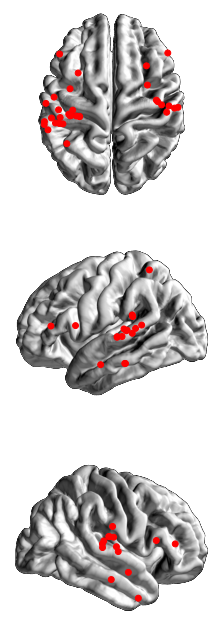

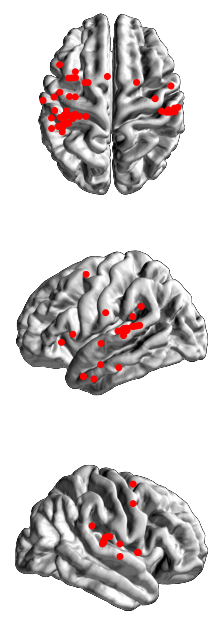

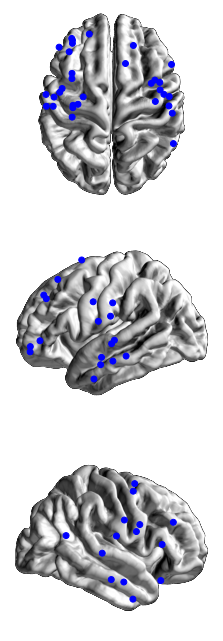

In [44]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''


        
for o, sound in enumerate(['speech','music', 'rest']):
    fig, ax= plt.subplots(3,1, figsize=(3,9))
    if sound=='rest':
        colors='blue'
    else:
        colors='red'
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(eng_simple[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(eng_simple[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(eng_simple[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((eng_simple[sound][subject]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=colors, s=35*np.ones(len(x_h)), marker='o', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])
    
    plt.tight_layout(pad=0.35)
    plt.savefig(path+'figure/brain_plots_all_channels_thres6std_zscoring_AE'+sound+'.png', dpi=600)


In [51]:
for o, sound in enumerate(['speech','music', 'rest']):
    for isub,subject in enumerate(subject_list[:-16]):            
           
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            print(f['atlasses'].keys())
            print(f['atlasses']['Brainnetome'][...][0][:5])

            
            #print('chnames', f['chnames'].shape)
            

<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'STG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'Hipp,'
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'FuG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'STG, '
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainnetome', 'Brainnetome_corrected', 'Desikan_Killiany', 'Desikan_Killiany_visbrain', 'Destrieux', 'JuBrain', 'VTPM', 'Yeo17', 'Yeo7']>
b'Hipp,'
<KeysViewHDF5 ['AAL', 'AFNI', 'BrainWeb', 'Brainne

# The code for figure 3 - the study of troughs

Here we repeat the exact procedure as before, selecting not the most correlated windows of time but the worst correlated ones.

In [138]:
ind={}
ind_all={}

for sound in sound_list:
    
    ind[sound]={}
    corr_thres=np.percentile(dcorr_all[sound], 1)
    ind_all[sound]=np.where(dcorr_all[sound]<corr_thres)[0]
   
    """for subject in subject_list:
    
        corr_thres=np.percentile(dcorr[sound][subject], 1)

        ind[sound][subject]=np.where(dcorr[sound][subject]<corr_thres)[0]"""


Computation of the time indices corresponding to the time windows in which the inter-subject correlation is lower.

In [139]:
index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

m=min(len(index_all['speech']), len(index_all['music']))
print(len(index_all['speech']), len(index_all['music']))
for sound in ['speech', 'music']:
    index_all[sound]=index_all[sound][:m]
    


1755 2672


The null models for all the conditions. This procedure as a not indifferent computational cost. Because of that we save the results in the end. 

In [140]:
n_iterations=1000

engagement={}
engagementr={}

meta_engagement={}
engagement_null_mean={}
engagement_null_std={}
engagement_null_mean['speech']={}
engagement_null_std['speech']={}
engagement_null_mean['music']={}
engagement_null_std['music']={}
data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
    
    
    #speech null model
    avalanches=av.go_avalanches(zdata['speech'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['speech'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['speech'][subject]=np.std(engagement_null, axis=0)
    
    
    #music null model
    avalanches=av.go_avalanches(zdata['music'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean['music'][subject]=np.mean(engagement_null, axis=0)
    engagement_null_std['music'][subject]=np.std(engagement_null, axis=0)
    
    
for sound in ['music', 'speech']:
    
    engagement[sound]={}    
    engagementr[sound]={}
    meta_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index_all[sound],:]
        print(min(np.sum(aval, axis=1)))
                                                           
        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
        
        meta_engagement[sound][subject]=(engagementt-engagement_null_mean[sound][subject])/engagement_null_std[sound][subject]
           
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])
        
sv.saving(engagement, path+'engagement_troughs')
sv.saving(meta_engagement, path+'meta_engagement_troughs' )


2.7761437719778965
2.9744978125454247


KeyboardInterrupt: 

Here we threshold the engagement in the 2 different methods.A 'yes' is printed in the terminal each time a subject has some channels with an engagement higher then the threshold.

In [144]:
engagement=sv.loading( path+'engagement_troughs')
meta_engagement=sv.loading( path+'meta_engagement_troughs')

enga={}
for sound in ['speech','music']:
    enga[sound]={}
    for subject in subject_list:
        #thress=5
        thress=max(meta_engagement[sound][subject])
        print(thress, max(engagement[sound][subject]))
        if thress < max(engagement[sound][subject]):
            print('')
            print('yes')
        enga[sound][subject]=np.where(engagement[sound][subject]>thress,1,0)


3.7998929169443563 4.134790647162713

yes
5.586756477841421 4.718148669486915
3.897957868655255 3.9713051055071427

yes
3.79678378374912 4.364133123841681

yes
4.3559974375713475 3.407174767793895
3.645544515507889 6.665640415257806

yes
2.643907478921373 3.268139541907688

yes
3.2608735562391455 3.9652057131760623

yes
4.614030478292361 3.965508714305009
4.766757084314771 6.18522862302905

yes
4.820578801577677 3.3296571352172126
5.7010461188813855 6.019540189847105

yes
7.443818483509169 8.816905795007951

yes
3.771900333146485 4.086600947927816

yes
3.9202847831292638 4.033433175681596

yes
5.2039261368737115 6.516833680353489

yes
3.737692338974128 3.4092575386420267
4.783188250946411 5.03632352093113

yes
3.334623673923427 3.1870984320073794
5.708112798665167 5.136790149186428
4.466470850333907 10.18090042297443

yes
4.561096763715792 4.623685095650037

yes
3.71740478894777 4.34218587341388

yes
3.9112376853890187 3.7253402711755044
5.664487334830701 5.457437808822177
2.6790683052

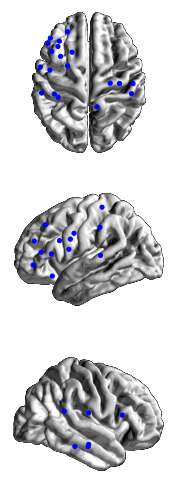

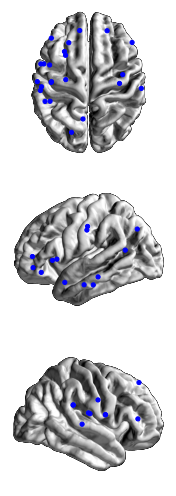

In [147]:

'''
#plotting
plt.figure(figsize=(3,1.7))
for subject in subject_list:
    plt.plot(mean_eng[subject])
plt.title('eng H - all subjects')
plt.xticks([0,1,2], ['speech','music','rest'], fontsize=10)
plt.ylabel('mean eng', fontsize=10)
plt.tight_layout()
plt.savefig(path+'figure/'+ 'engament of H - across conditions - all subjects', dpi=600)
plt.show()
plt.close()'''


        
for o, sound in enumerate(['speech','music']):
    fig, ax= plt.subplots(3,1, figsize=(3,7))
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(engagement[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(engagement[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((engagement[sound][subject]))[i,:]))
                x_h = coordinates
                
                
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][left_i]))
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject][right_i]))
                
            if orientation =='top':
                axes.scatter(*x_h.T, color='blue', s=70*np.ones(len(x_h)), marker='.', alpha=(enga[sound][subject]))

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(path+'figure/brain_plots_all_channels_troughs_maxmetasound_'+sound+'.png', dpi=600)


## Engagement of Helsch Gyrus, is it changing across conditions in the most inter-subject correlated window of time?

In this part we are interested in the study of the engagement of the Helsch gyrus. 



In [124]:
ch_H_i=sv.loading(path+'H_channels_indices_subjects')

In [125]:
eng_simple=sv.loading(path+'engagement_peaks_simple')    

In [126]:
sound_list

['rest', 'music', 'speech']

Plotting

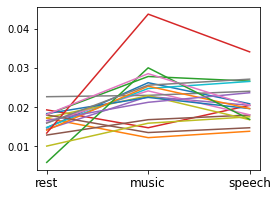

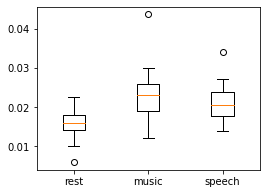

In [149]:


for sound in sound_list:
    zdata=
    for subject in subject_list:

        eng_simple[sound][subject]=np.sum



fs=12
engag={}        
for subject in subject_list:
    engag[subject]=[]
    for sound in sound_list:
        engag[subject].append(np.mean(eng_simple[sound][subject][ch_H_i[subject]]))
        

plt.figure(figsize=(4,3))
for subject in subject_list:
    plt.plot([np.mean(eng_simple['rest'][subject][ch_H_i[subject]]),np.mean(eng_simple['music'][subject][ch_H_i[subject]]),np.mean(eng_simple['speech'][subject][ch_H_i[subject]])])
plt.xticks([0,1,2], sound_list, fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_subjects_lines.png', dpi=600)
plt.show()
plt.close()

engag_boxplot=np.zeros((3,19))

for i, sound in enumerate(sound_list):
    for j, subject in enumerate(subject_list):
        engag_boxplot[i,j]=engag[subject][i]

plt.figure(figsize=(4,3))
plt.boxplot(list(engag_boxplot), labels=sound_list)
#plt.legend(fontsize=fs)
#plt.ylabel('H norm AE', fontsize=fs)
#plt.tight_layout()
plt.savefig(path+'figure/h_engagement_boxplot.png', dpi=600)
plt.show()
plt.close()  



    

    

pvalue computation

In [137]:
ent_random_=np.concatenate((engag_boxplot[0,:], engag_boxplot[2,:]))

real_differ=np.mean(engag_boxplot[2,:])-np.mean(engag_boxplot[0,:])
list_random_corr=[]
count=0
n_it=100000
for i in range(n_it):
    indices=random.sample(range(38), 19)
    ent_random1=ent_random_[indices]
    indices=random.sample(range(38), 19)
    ent_random2=ent_random_[indices]
    differ=np.mean(ent_random1)-np.mean(ent_random2)
    list_random_corr.append(differ)
    if differ>real_differ:
        count+=1

pvalue=count/n_it

if pvalue==0:
    print('for speech vs rest, pvalue <', 1/n_it)
else:
    print('for speech vs rest, pvalue =', pvalue)

ent_random_=np.concatenate((engag_boxplot[0,:], engag_boxplot[1,:]))

real_differ=np.mean(engag_boxplot[1,:])-np.mean(engag_boxplot[0,:])
list_random_corr=[]
count=0
n_it=100000
for i in range(n_it):
    indices=random.sample(range(38), 19)
    ent_random1=ent_random_[indices]
    indices=random.sample(range(38), 19)
    ent_random2=ent_random_[indices]
    differ=np.mean(ent_random1)-np.mean(ent_random2)
    list_random_corr.append(differ)
    if differ>real_differ:
        count+=1

pvalue=count/n_it        
if pvalue==0:
    print('for music vs rest, pvalue <', 1/n_it)
else:
    print('for music vs rest, pvalue =', pvalue)

    

for speech vs rest, pvalue < 1e-05
for music vs rest, pvalue < 1e-05


## VARIOUS ANALYSIS....

In the following part we are going to study the correlation between the dynamical correlation in time window and the engagement in time windows.

1 THE ENGAGEMENT IN TIME WINDOW

In [206]:
n_iterations=400

engagement_null_mean={}
engagement_null_std={}

data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

for isub, subject in enumerate(subject_list):
    
    zdata=data[subject]
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
           
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), 200)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)


2.7507264122036497
2.8138171563785437
2.7654285000333187
3.334984151824247
2.7761437719778965
2.9744978125454247
2.774284818922206
2.7985919037396925
2.734310175019014
2.803148765547773
2.8552720483703933
2.78534246404477
2.7331326834817284
2.897258743666651
2.79738475441734
2.750861898649132
2.8089245753814596
2.818625307029934
2.7742837529435107


In [225]:
window_length=50
time_interval=1
d_engagement={}

for sound in ['speech','music']:
    d_engagement[sound]={}
    
    for subject in subject_list:
        zdata=data[subject][sound]
        thres=np.percentile(data[subject]['rest'], 99)
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata.T, thre=thres, direc=0, binsize=2)
        aval=avalanches['Zbin'].T
        t_length=len(aval[0,:])
        n_w=len(np.arange(0, t_length - window_length, time_interval))
        d_engagement[sound][subject]=np.zeros((len(aval),n_w))
        
        print(d_engagement[sound][subject].shape)
        windows=np.arange(0, t_length- window_length, time_interval)
        for i in range(n_w):
            t_start=windows[i]
            d_engagement[sound][subject][:,i] =(np.sum(aval[:,t_start:t_start+window_length], axis=1)-engagement_null_mean[subject])/engagement_null_std[subject]
            
            
            
            
            


(168, 143)
(107, 143)
(123, 143)
(147, 143)
(108, 143)
(167, 143)
(135, 143)
(139, 143)
(116, 143)
(117, 143)
(109, 143)
(110, 143)
(151, 143)
(157, 143)
(86, 143)
(146, 143)
(121, 143)
(150, 143)
(115, 143)
(168, 144)
(107, 144)
(123, 144)
(147, 144)
(108, 144)
(167, 144)
(135, 144)
(139, 144)
(116, 144)
(117, 144)
(109, 144)
(110, 144)
(151, 144)
(157, 144)
(86, 144)
(146, 144)
(121, 144)
(150, 144)
(115, 144)


In [212]:
len(np.arange(0, - window_length, time_interval))

143

In [215]:
(len(aval[0,:])-window_length)/time_interval


142.675

In [222]:


#computations
for sound in sound_list:
    dcorr[sound]={}
    dcorr_matrix[sound]=[]
    mat=[]
    
    for isub, subject in enumerate(subject_list):
        dcorr[sound][subject]=[]
        
        for i in np.arange(0,len(rss_matrix[sound][0,:])-window_length, time_interval):
            dcorr[sound][subject].append(np.sum((np.corrcoef(rss_matrix[sound][:,i:i+window_length])-np.identity(19))[isub,:])/18)
        
        #print(len(dcorr[sound][subject]))
        mat.append(dcorr[sound][subject])
        
    dcorr_matrix[sound]=np.array(mat)
    dcorr_all[sound]=np.mean(np.array(mat), axis=0)
    print('la lunghezza è', dcorr_matrix[sound].shape)

la lunghezza è (19, 141)
la lunghezza è (19, 144)
la lunghezza è (19, 143)


In [229]:
ch_H_i


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114]

The results of this computation

In [173]:
d_engagement['speech'][subject]=np.array(d_engagement['speech'][subject])

In [165]:
final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i]
        final_channels_all[subject]

(57787, 115)

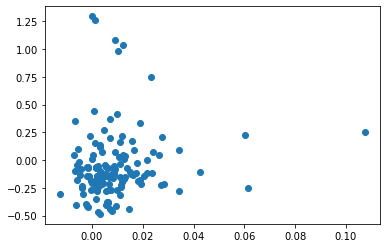

In [237]:
plt.plot(dcorr_all['speech'], np.mean(d_engagement['speech'][subject_list[8]], axis=0), 'o')

In [250]:
sr={}
pval={}
for sound in ['speech', 'music']:
    sr[sound]={}
    pval[sound]={}
    for subject in subject_list:
        ch_i=[i for i, ch in enumerate(final_channels_all[subject]) if ch in final_channels_H]
        print(ch_i)
        n_ch=len(d_engagement[sound][subject][ch_i, :])
        sr[sound][subject]=np.zeros(n_ch)
        pval[sound][subject]=np.zeros(n_ch)

        
        for ch in ch_i:
            sr[sound][subject][ch], pval[sound][subject][ch] = stats.spearmanr(dcorr_all[sound], d_engagement[sound][subject][ch,:])


        
        

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


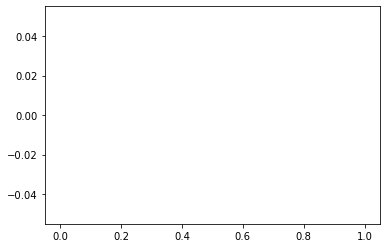

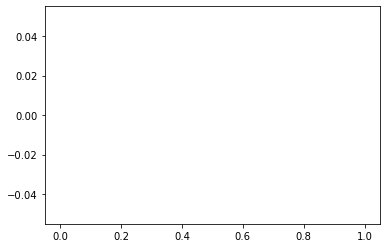

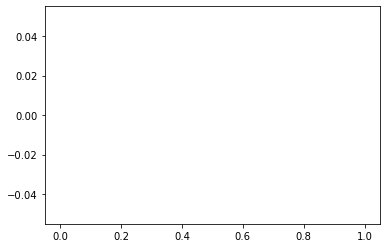

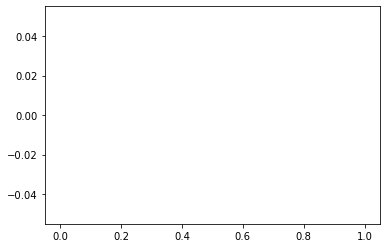

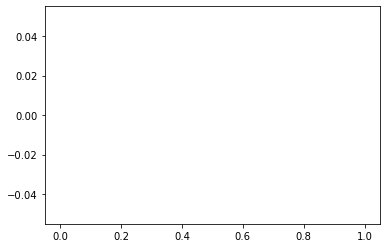

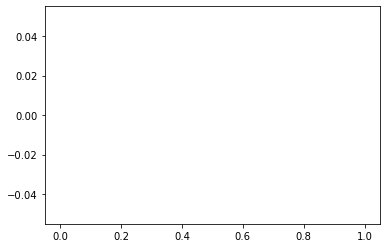

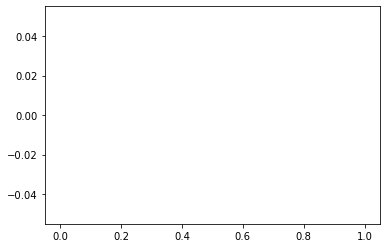

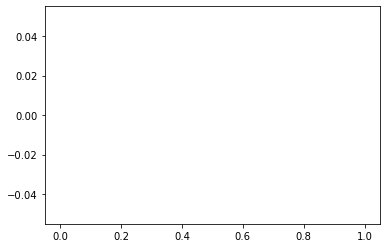

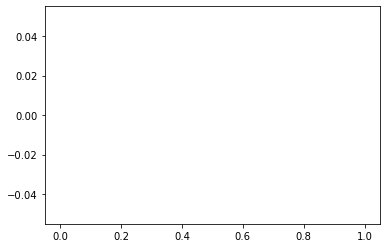

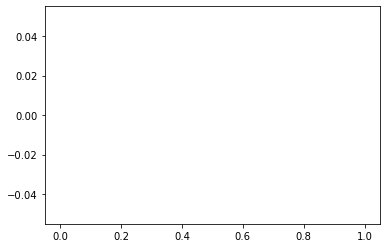

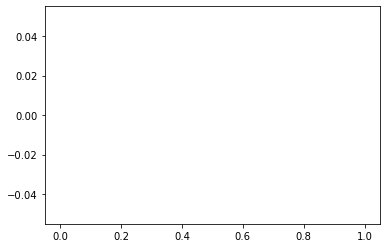

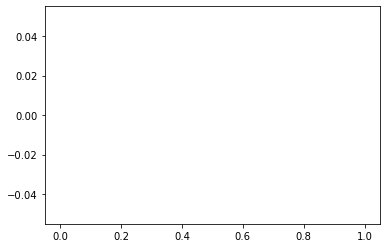

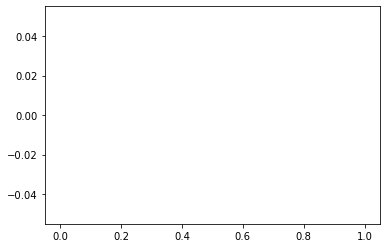

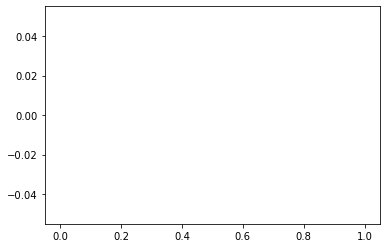

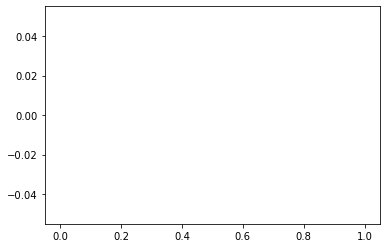

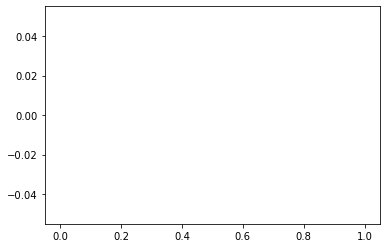

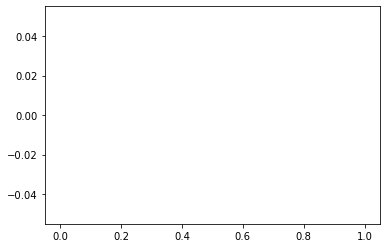

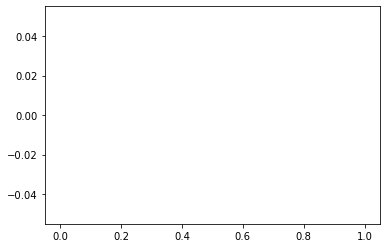

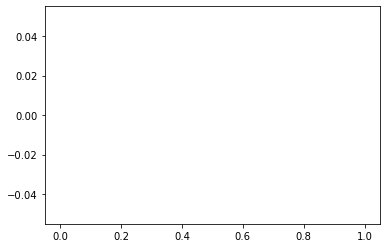

In [249]:
for subject in subject_list:
    
    for sound in ['music','speech']:
        plt.hist(sr[sound][subject])
    plt.show()
    plt.close()

In [176]:
d_engagement['speech'][subject][5,:]


array([-3.64271566, -3.64271566, -3.64271566, ..., -3.64271566,
       -3.64271566, -3.64271566])

In [150]:
index=dict()
for sound in sound_list:
    
    index[sound]={}
    for subject in subject_list:

        aa=set()
        for i in ind[sound][subject]:
            aa.update(np.arange(i,i+window_length))
            
        index[sound][subject]=list(aa)

            
for subject in subject_list:
    m=min(len(index['speech'][subject]), len(index['music'][subject]))
    for sound in ['speech', 'music']:
        index[sound][subject]=index[sound][subject][:m]
        

The indices of the time steps of the binarized dataset corresponding to the most correlated time windows (computed above), are computed in the following way. Below is for the moment when each subject is particularly correlated with the others.

In [114]:

#%%
entropy=dict()
mean_eng=dict()
burstiness=dict()
n_iterations=100
engagement=dict()
engagementr={}
engagement_null_mean={}
engagement_null_std={}

sound='rest'
for isub, subject in enumerate(subject_list):
    
    zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata['rest'], 99)
    print(thres)

        
        
    #avalanches dictionaries are computed using the functions of Utils_avalanches.py
    avalanches=av.go_avalanches(zdata['rest'].T, thre=thres, direc=0, binsize=2)
        
    m=len(list(index['speech'][subject]))
    print(m, len(list(index['music'][subject])))      

            
    engagement_null=[]
    for i in range(n_iterations):
        indices=random.sample(range(len(avalanches['Zbin'])), m)
        engagement_null.append(np.sum(avalanches['Zbin'][indices,:], axis=0))

    engagement_null=np.array(engagement_null)
    engagement_null_mean[subject]=np.mean(engagement_null, axis=0)
    engagement_null_std[subject]=np.std(engagement_null, axis=0)
        
for sound in ['music', 'speech']:
    engagement[sound]={}
    engagementr[sound]={}
    
    for subject in subject_list:
        zdata=sv.loading( path+"data_"+datatipe+'_'+subject) #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata['rest'], 99)
        print(thres)
        
        
        corr_thres=np.percentile(dcorr[sound][subject], 99)
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[sound].T, thre=thres, direc=0, binsize=2)
        
        print(avalanches['Zbin'].shape)
        aval=avalanches['Zbin'][index[sound][subject],:]

        engagementt=np.sum(aval, axis=0)

        engagement[sound][subject]=(engagementt-engagement_null_mean[subject])/engagement_null_std[subject]
            
        engagementr[sound][subject]=(engagement[sound][subject]-min(engagement[sound][subject]))/max(engagement[sound][subject]-min(engagement[sound][subject]))
        
        print(engagement[sound][subject])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/matte/OneDrive/Documenti/matteo/data_hgenv_down100_sub-14c725b6b803'